In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

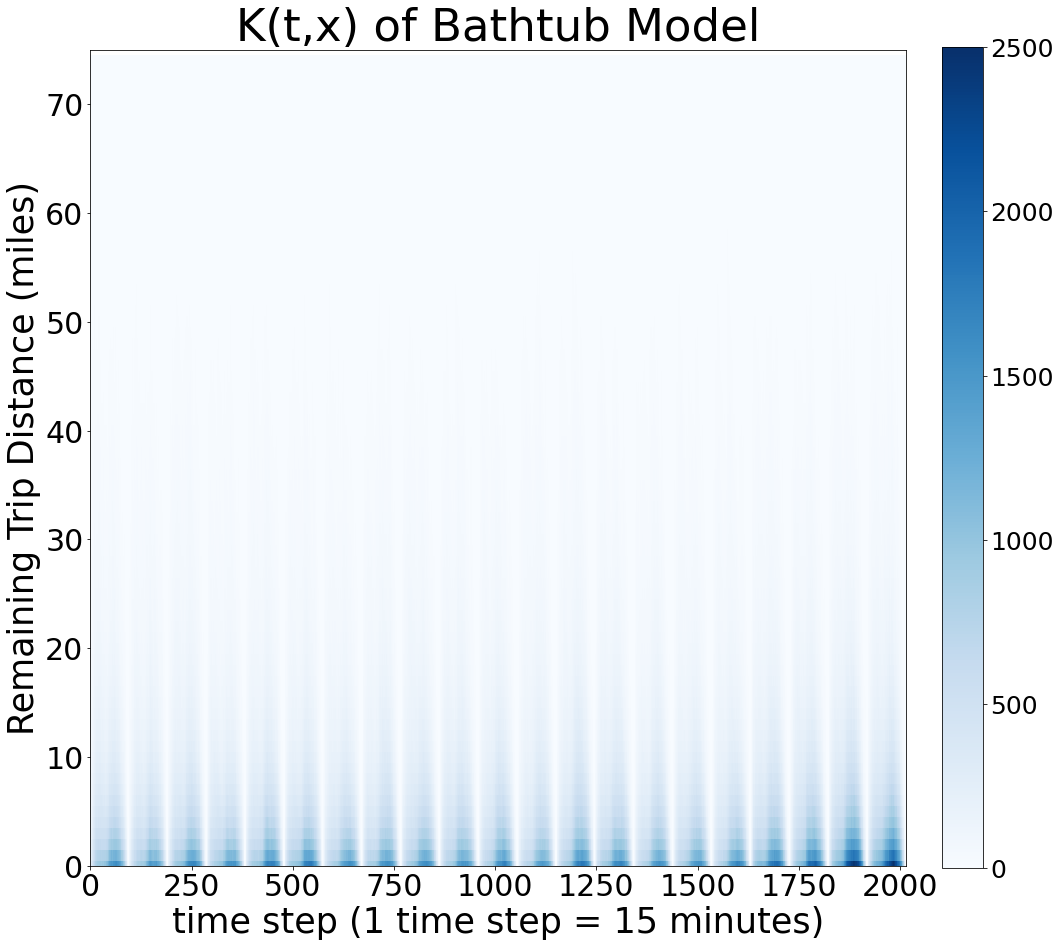

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 3 # unit: miles
Size_timestep = 2 # 2: 30min, 3: 60min
size_input = int(N_diststep/Size_diststep)*int(N_timestep/Size_timestep) # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  25200
N_u =  5040
N_f =  10080


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

In [9]:
X.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04054054, 0.04054054, 0.04054054, ..., 0.04054054, 0.04054054,
        0.04054054],
       [0.08108108, 0.08108108, 0.08108108, ..., 0.08108108, 0.08108108,
        0.08108108],
       ...,
       [0.89189189, 0.89189189, 0.89189189, ..., 0.89189189, 0.89189189,
        0.89189189],
       [0.93243243, 0.93243243, 0.93243243, ..., 0.93243243, 0.93243243,
        0.93243243],
       [0.97297297, 0.97297297, 0.97297297, ..., 0.97297297, 0.97297297,
        0.97297297]])

In [10]:
T.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)]

array([[0.00000000e+00, 9.92555831e-04, 1.98511166e-03, ...,
        9.97518610e-01, 9.98511166e-01, 9.99503722e-01],
       [0.00000000e+00, 9.92555831e-04, 1.98511166e-03, ...,
        9.97518610e-01, 9.98511166e-01, 9.99503722e-01],
       [0.00000000e+00, 9.92555831e-04, 1.98511166e-03, ...,
        9.97518610e-01, 9.98511166e-01, 9.99503722e-01],
       ...,
       [0.00000000e+00, 9.92555831e-04, 1.98511166e-03, ...,
        9.97518610e-01, 9.98511166e-01, 9.99503722e-01],
       [0.00000000e+00, 9.92555831e-04, 1.98511166e-03, ...,
        9.97518610e-01, 9.98511166e-01, 9.99503722e-01],
       [0.00000000e+00, 9.92555831e-04, 1.98511166e-03, ...,
        9.97518610e-01, 9.98511166e-01, 9.99503722e-01]])

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [11]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [12]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [13]:
X_u_train.shape

(5040, 2)

In [14]:
X_u_test.shape

(20160, 2)

In [15]:
X_u_train

array([[0.36486486, 0.12704715],
       [0.72972973, 0.41588089],
       [0.44594595, 0.97270471],
       ...,
       [0.72972973, 0.39801489],
       [0.64864865, 0.14094293],
       [0.97297297, 0.81488834]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [16]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [17]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.0044341959628528558 0.0081069663445699526 0.00076142558113575967 0.8030252939018767
0.0043677160830557244 0.0080707697257705671 0.00066466244034088084 0.8016789250990877
0.0043037693739778095 0.0080189260834207434 0.000588612664534875 0.7996702785382325
0.0042233990826585771 0.0078874259170388077 0.00055937224827834714 0.7938143912561568
0.0040697988377742618 0.0075886592778242491 0.00055093839772427425 0.7799730046264917
0.0039479535956182133 0.0073916213984778741 0.00050428579275855188 0.7703914679034483
0.0039156164893516037 0.0073568367086182954 0.00047439627008491133 0.7685161218982857
0.0039007162865160243 0.00735193094868188 0.00044950162435016818 0.768189481783238
0.0038718255669811948 0.0073515798204093329 0.00039207131355305659 0.7681042739311665
0.0038420934159524656 0.0073468730372950909 0.00033731379460983984 0.7679699155595406
0.0038227609850435382 0.00732868860347003 0.00031683336661704654 0.7672684926454268
0.0038139916811897896 0.0073216700746666251 0.000306313287712

0.0024450806298960035 0.0042083781942544125 0.00068178306553759471 0.5913964137963075
0.0024436463281500525 0.0041836351460297783 0.00070365751027032654 0.5898232459151379
0.0024434304411879619 0.004186078611645082 0.0007007822707308422 0.589938514240848
0.0024410420740935742 0.0041858425090598571 0.00069624163912729146 0.5898443709191334
0.0024403234837779525 0.0041828475349852748 0.00069779943257063006 0.5896160375039682
0.0024399972957068672 0.0041728142391727185 0.00070718035224101561 0.5889033610495433
0.0024397614221379265 0.00416872668456419 0.00071079615971166314 0.5885742897309892
0.0024392757271184708 0.00417173907671239 0.00070681237752455146 0.588797560438951
0.0024389292592706885 0.004178200478062527 0.00069965804047884958 0.5892444364670715
0.0024379407444930605 0.0041808398100808448 0.00069504167890527583 0.5894477581970233
0.0024371092055357041 0.0041787688701325817 0.00069544954093882694 0.5892521575212227
0.0024366367028817774 0.0041705364924003469 0.00070273691336320

0.0024190502009031403 0.0041231525577676729 0.00071494784403860806 0.5857541601796726
0.002418938606370432 0.0041187313544150013 0.0007191458583258631 0.5854748336999449
0.00241887084619505 0.004118912248017634 0.00071882944437246616 0.5855081762050963
0.0024188588136869566 0.0041219641704528078 0.000715753456921106 0.5857071873086768
0.0024188368197434161 0.0041190030634129663 0.00071867057607386594 0.5855269920684327
0.0024188256242950578 0.0041188778802448847 0.00071877336834523064 0.5855251657854027
0.0024188107175941273 0.00411995114338455 0.00071767029180370458 0.5855924411033678
0.0024187841670536385 0.0041204986284123866 0.00071706970569489 0.5856321998656081
0.0024187383770827155 0.0041202641742782648 0.0007172125798871659 0.5856208466534636
0.0024186725587486716 0.004119455898254379 0.00071788921924296426 0.585576289874249
0.0024185304239753786 0.0041171046415065544 0.0007199562064442031 0.5854420461246929
0.0024183657406061073 0.004112306699378546 0.00072442478183366843 0.58

0.0024027237584000861 0.0041114076217097359 0.00069403989509043615 0.5858500275026862
0.0024026306680776646 0.0041114869734239032 0.000693774362731426 0.5858636287430937
0.002402417505517414 0.0041139398588442 0.00069089515219062758 0.5860621003764261
0.0024023276756152917 0.0041112961028778525 0.000693359248352731 0.5859580097155103
0.0024022394944005587 0.0041222034159547494 0.00068227557284636776 0.5866884308933409
0.00240219855876897 0.0041188845173363766 0.00068551260020156325 0.5864905613285316
0.0024021599328382451 0.0041074946197043084 0.00069682524597218141 0.585739873513973
0.002402050065562383 0.0041131877814936917 0.00069091234963107454 0.5861153451161973
0.0024019880925677125 0.0041166658713564655 0.00068731031377895963 0.5863540845502583
0.00240191682790952 0.004118011031211447 0.00068582262460759285 0.5864801908642706
0.0024017289178318146 0.0041181974321221051 0.00068526040354152423 0.5864993411513554
0.0024015001870466689 0.0041146512774453631 0.0006883490966479751 0.5

0.0023940147515076429 0.0040928096279389562 0.00069521987507632982 0.585135540778328
0.0023940121257250485 0.0040925739448664181 0.00069545030658367914 0.5851163318412841
0.0023940003700215684 0.0040918604913060246 0.00069614024873711244 0.5850502210281388
0.0023939875869608842 0.004091432638144636 0.00069654253577713216 0.5850073442234451
0.0023939696160986709 0.004090785472391844 0.00069715375980549754 0.5849608443966205
0.0023939650865934426 0.0040919197071360774 0.000696010466050808 0.5850417581301077
0.0023939604295360748 0.0040917215567880163 0.00069619930228413359 0.5850480392513462
0.0023939474934520167 0.0040922659022087776 0.0006956290846952556 0.5850869136417752
0.0023939428627422674 0.0040919883287295821 0.000695897396754953 0.5850698183770725
0.0023939349590095305 0.0040919563745594745 0.0006959135434595863 0.5850767856171208
0.0023939307312258215 0.0040914725952647876 0.00069638886718685557 0.5850430454094099
0.0023939262251056873 0.0040911218746356361 0.00069673057557573

0.0023930617851552378 0.0040829178850148281 0.00070320568529564764 0.58439015746308
0.0023930603912655215 0.00408296768989237 0.000703153092638673 0.5843910910599058
0.0023930596285930863 0.0040825489099146654 0.00070357034727150717 0.5843624627447344
0.0023930582804461689 0.0040829997104515642 0.00070311685044077373 0.5843891457123553
0.0023930560876570697 0.0040832069120080011 0.000702905263306138 0.5844004507256472
0.0023930487787232804 0.00408366472929972 0.00070243282814684072 0.5844251259787653
0.002393043652429322 0.0040839240451177265 0.00070216325974091726 0.5844406049114741
0.0023930345896302409 0.0040844416660392718 0.00070162751322121034 0.5844734191496661
0.0023930248941116342 0.0040868746117704129 0.0006991751764528556 0.5846254168909469
0.0023929920796552785 0.0040877569847779906 0.0006982271745325664 0.584666647490085
0.0023929536789452613 0.004088982200696774 0.00069692515719374894 0.5847328109647467
0.002392913385385042 0.0040905000780108031 0.000695326692759281 0.584

0.0023915912229774505 0.0040816918584397 0.00070149058751520135 0.5842896442297655
0.0023915792112179095 0.00408248106813215 0.00070067735430366911 0.584330687439283
0.0023915754563929525 0.0040817655928077146 0.00070138531997819 0.5842848121810209
0.0023915717875720166 0.0040810554750168636 0.00070208810012716949 0.5842311077554696
0.0023915680129238124 0.004081645765434027 0.00070149026041359806 0.5842664383823813
0.0023915656889449714 0.004081842042091245 0.00070128933579869767 0.5842828981370507
0.0023915597864088466 0.0040818809714297678 0.00070123860138792576 0.5842922492398511
0.0023915584382790287 0.0040834468678634739 0.000699670008694584 0.5843980634514392
0.0023915539931986746 0.0040820378571662782 0.00070107012923107054 0.5843116207986282
0.0023915510178228686 0.0040816402569088233 0.000701461778736914 0.5842824998923546
0.0023915447118852849 0.00408190323824558 0.00070118618552498981 0.5842984905407204
0.0023915422685848254 0.0040815057526408247 0.00070157878452882614 0.58

0.0023905986097708075 0.0040812220139046246 0.00069997520563699065 0.5843256328414371
0.0023905866826285757 0.0040811305344745624 0.000700042830782589 0.5843109092127576
0.00239057237454628 0.0040792993193521556 0.00070184542974040384 0.584191559759567
0.0023905649211118634 0.0040802970567125263 0.00070083278551120033 0.5842300428988951
0.0023905545947482958 0.0040812491035486231 0.00069986008594796843 0.5842977523056593
0.0023905495131178343 0.0040809948826521936 0.00070010414358347487 0.5842842476979778
0.0023905405145070858 0.00408129538557324 0.000699785643440931 0.5843037691077205
0.0023905341072606679 0.0040798378581290559 0.00070123035639228022 0.5842007614888123
0.0023905230069142967 0.0040811846900515062 0.00069986132377708725 0.5842865574561107
0.0023905152583020345 0.004080935365505951 0.0007000951510981176 0.5842675277868492
0.0023905054580751562 0.0040808449689159762 0.00070016594723433566 0.5842656675985866
0.0023904955993673434 0.0040804442428585136 0.000700546955876173 

0.0023838146720851659 0.0040714143750078769 0.000696214969162455 0.5835261525259864
0.002383667999825154 0.0040711598179655915 0.00069617618168471671 0.5835340807232177
0.0023834794447147975 0.0040729224446773155 0.00069403644475227958 0.5836587420612653
0.0023832239838334048 0.0040772794298151588 0.00068916853785165111 0.5839888364360711
0.0023826956437709356 0.00407258406560415 0.00069280722193772106 0.5835927570026754
0.0023824386841150044 0.0040791566559368192 0.0006857207122931894 0.5840463750496009
0.00238213613024685 0.0040850587850238245 0.00067921347546987562 0.5844356755820216
0.0023819005031365361 0.0040848495435598783 0.000678951462713194 0.5845002914800428
0.0023814662995317384 0.0040669780439706645 0.00069595455509281225 0.5833905380823909
0.0023808895090192158 0.0040735167227836247 0.00068826229525480729 0.5838353993114479
0.0023806027104092044 0.004067238566063518 0.00069396685475489074 0.5834315583177356
0.0023798779287375832 0.0040708560201352315 0.0006888998373399346

0.0023182629912409138 0.0039887729448892 0.00064775303759262773 0.5782337427309994
0.0023181112856129962 0.00398877157486172 0.00064745099636427216 0.578242709384289
0.00231795819235906 0.0039869099366996886 0.00064900644801843142 0.5781768423911758
0.0023178109700795579 0.0039843164177495094 0.00065130552240960616 0.5780277167368817
0.0023177187909292594 0.0039829313360512661 0.00065250624580725234 0.5779553771699392
0.0023176431547717912 0.0039820692407421549 0.00065321706880142787 0.5778695685260461
0.0023175414846404508 0.0039821592417179121 0.00065292372756298926 0.5778176611299577
0.0023173704943586257 0.0039813353258705613 0.00065340566284669032 0.5777166198255242
0.0023169089884858985 0.0039798154159275878 0.00065400256104420967 0.577536578024796
0.0023164465415465348 0.0039754437177666538 0.00065744936532641555 0.5771551521202561
0.0023161095713215654 0.0039710415068106861 0.000661177635832445 0.5768480059169229
0.0023158271380736861 0.0039675441638527273 0.0006641101122946445

0.002301122665713284 0.0039452923203169392 0.00065695301110962933 0.575211821248421
0.0023010471994756782 0.0039446956471109445 0.00065739875184041188 0.5751768899544301
0.0023009244002033784 0.0039449973676620887 0.00065685143274466862 0.5752048271785909
0.0023008067953038821 0.0039425140550555472 0.00065909953555221684 0.5750360963311469
0.002300702173299014 0.0039387304367537439 0.00066267390984428359 0.5747554916061088
0.0023005988320809459 0.0039368702696291908 0.00066432739453270082 0.5745849535364702
0.0023005033049157391 0.0039369752051233824 0.00066403140470809618 0.5745485949838669
0.0023004335807510182 0.0039383438534611095 0.0006625233080409269 0.5746222417914869
0.0023003787438726467 0.0039409199045524878 0.00065983758319280539 0.5747865968436714
0.0023002797155497038 0.0039400077988887439 0.00066055163221066338 0.574736886938875
0.002300173524084364 0.003939533848378354 0.00066081319979037381 0.5747545542738124
0.002300138398165149 0.0039390939711991795 0.0006611828251311

0.0022934039330317086 0.0039348296007348281 0.000651978265328589 0.5748892271862005
0.0022933708346201632 0.0039345673599266891 0.00065217430931363736 0.5748809913168633
0.0022933531578916556 0.0039341421003198677 0.00065256421546344364 0.5748698028784706
0.002293336357725283 0.0039349726539712982 0.000651700061479268 0.5749390433461536
0.0022933185458860771 0.003934951372141662 0.00065168571963049218 0.5749447088788523
0.002293290285482984 0.0039359407076269342 0.00065063986333903389 0.5750339513542853
0.0022932614097260695 0.0039358632567472168 0.00065065956270492231 0.5750390287518291
0.0022932357882285525 0.0039374701660314856 0.00064900141042561923 0.5751549176138656
0.00229321497119897 0.003936330212620181 0.00065009972977775831 0.575079957365079
0.0022931903257433273 0.0039363617876429875 0.00065001886384366688 0.5750765923389858
0.00229315063316189 0.0039372925820224522 0.00064900868430132781 0.5751271901470959
0.0022931135223296308 0.0039363261361202674 0.00064990090853899384 

0.0022894897267434666 0.0039316682008651554 0.00064731125262177769 0.5745825689300832
0.0022894851975370761 0.00393186168523923 0.00064710870983492193 0.5745926115591271
0.0022894820746128448 0.0039315075168678193 0.0006474566323578702 0.5745722287723888
0.0022894784668765229 0.0039311558338879782 0.00064780109986506721 0.5745472000933736
0.0022894743611600018 0.0039314376416675328 0.0006475110806524703 0.5745617539358739
0.0022894712392223472 0.0039309522437698833 0.00064799023467481125 0.574528078945108
0.0022894676784447616 0.0039308245659254977 0.00064811079096402532 0.574523645291753
0.0022894651464583269 0.0039314280320238131 0.00064750226089284053 0.5745683404793495
0.0022894636702426442 0.0039312590597709489 0.00064766828071433937 0.5745551741070657
0.0022894618975988906 0.0039312462803578882 0.00064767751483989265 0.5745558026397019
0.0022894597410255675 0.0039314294726677836 0.00064749000938335132 0.5745685155906277
0.0022894575414081244 0.0039314905441169773 0.00064742453869

0.0022868005165446533 0.0039260603635726046 0.00064754066951670211 0.574227992431651
0.0022867936392108631 0.0039263863827754325 0.00064720089564629369 0.5742470135368256
0.0022867881073531621 0.0039265307852190514 0.00064704542948727307 0.5742559251001799
0.0022867745737791033 0.0039266502960475045 0.00064689885151070214 0.5742712970372801
0.0022867622596699677 0.0039269923144280312 0.00064653220491190419 0.5742879847396282
0.0022867484038712488 0.0039270710382033015 0.000646425769539196 0.5742915732496384
0.0022867400462422043 0.0039270308860131159 0.00064644920647129308 0.5742880741753242
0.0022867328245136471 0.0039268031828915209 0.00064666246613577375 0.5742696419351819
0.0022867257399564441 0.0039258408267100536 0.00064761065320283466 0.574202545539417
0.0022867213674480826 0.0039256683842123739 0.00064777435068379119 0.5741922175502419
0.0022867175414440157 0.0039256362695896446 0.00064779881329838686 0.5741915252709553
0.0022867134522984232 0.0039259554130626978 0.000647471491

0.0022846852870890568 0.0039219055611134116 0.000647465013064702 0.5741212269403237
0.0022846343184996947 0.0039222558663392177 0.00064701277066017183 0.5741111626258985
0.0022846071067020635 0.003926098267988805 0.00064311594541532186 0.5743730827570346
0.0022845460609950286 0.003924214188488471 0.00064487793350158579 0.5742204242876956
0.0022845058161024947 0.0039218158354591241 0.000647195796745865 0.5740845069064572
0.0022844512246131114 0.003921462420191946 0.00064744002903427682 0.5740796230084412
0.002284406226679699 0.0039219249218655061 0.00064688753149389161 0.5741133797336113
0.0022843660109400569 0.0039215676893421267 0.00064716433253798737 0.574060764961515
0.0022843244218198485 0.0039214876055004861 0.00064716123813921087 0.574054104519092
0.0022842853089110218 0.00392099486092963 0.00064757575689241317 0.5740080557921277
0.0022842508187104404 0.003920712601919769 0.000647789035501112 0.5739842019331385
0.0022842120458457368 0.00392057272297204 0.00064785136871943439 0.57

0.00228176381864357 0.003919089895052119 0.00064443774223502115 0.5736248129641176
0.0022817514042382842 0.00391899373889512 0.000644509069581448 0.573618743462947
0.0022817406556835968 0.0039192050928618539 0.00064427621850534007 0.5736364999501452
0.0022817326143433781 0.0039192285286712512 0.00064423670001550548 0.5736481974003936
0.00228171878400427 0.0039195820930371912 0.0006438554749713495 0.5736761625852991
0.0022817112446492718 0.0039200492631730746 0.00064337322612546875 0.573712139640123
0.0022817034990244927 0.0039200754670914812 0.00064333153095750444 0.5737162028634772
0.0022817000743467876 0.00392041497558004 0.00064298517311353566 0.5737359970316918
0.0022816976329560036 0.0039205719034839928 0.00064282336242801462 0.5737457689200695
0.0022816936655492715 0.0039206552901776687 0.00064273204092087414 0.5737498890089003
0.0022816874908598486 0.0039206530598805012 0.00064272192183919565 0.5737474492797596
0.0022816793268332085 0.0039203125351856835 0.00064304611848073367 0

0.0022796691327772321 0.0039112892235786878 0.0006480490419757763 0.5729912022320804
0.0022796506443788236 0.0039117892561138807 0.00064751203264376621 0.5730158927120348
0.0022796264093835456 0.0039111214921101938 0.00064813132665689764 0.5729599110057014
0.0022796063263542197 0.0039110467706595714 0.00064816588204886822 0.5729624274914821
0.0022795901234213579 0.0039099718389995677 0.00064920840784314854 0.5728794149834248
0.0022795869340035677 0.0039095016420454881 0.00064967222596164741 0.572839094962227
0.0022795684582874276 0.0039103864574700992 0.00064875045910475575 0.5728938556573291
0.0022795573584856923 0.0039113379426009487 0.000647776774370436 0.572955281032991
0.0022795354347151181 0.0039104805126508558 0.00064859035677938088 0.5728977306204527
0.0022795093925718607 0.00391144354424968 0.00064757524089404143 0.5729576264385953
0.002279478222146965 0.0039113832975347877 0.00064757314675914241 0.5729525748502996
0.0022794254698548593 0.0039115430981033206 0.0006473078416063

0.0022765038321876548 0.0039031090194857582 0.0006498986448895518 0.5723500249442205
0.0022764207571018429 0.0039023095552863031 0.00065053195891738255 0.5722891261826705
0.0022763619276297111 0.0039017567579326582 0.00065096709732676418 0.5722645941711605
0.0022763152967391533 0.003898175313526923 0.00065445527995138355 0.5720266859725841
0.0022762391592409652 0.0039002833780612681 0.0006521949404206625 0.5721633863774414
0.0022762100361586315 0.003901310782312662 0.00065110929000460082 0.5722113426130782
0.002276185157698713 0.0039009888414829703 0.000651381473914456 0.5721979126118778
0.0022761731928361141 0.0038995236799766447 0.00065282270569558341 0.5720876729458693
0.0022761574656706461 0.0038999552303078341 0.00065235970103345853 0.572112697322685
0.0022761398976297326 0.0039002046343516407 0.00065207516090782418 0.5721318312961639
0.0022761257453239453 0.0038999354433323155 0.00065231604731557464 0.5721114796008447
0.0022761155000638089 0.0038989145250770004 0.0006533164750506

0.0022718385136029609 0.0038835437428220727 0.000660133284383849 0.5705941040176791
0.0022717588477384519 0.0038845122020882304 0.00065900549338867307 0.5706500546729673
0.0022717073184629639 0.0038836243877642574 0.0006597902491616703 0.5705452537333037
0.0022716559143124934 0.0038816432419121753 0.00066166858671281149 0.5704146764684654
0.0022716325408938002 0.0038807332584263987 0.00066253182336120187 0.570351250103681
0.0022716121895798138 0.0038802151768012917 0.00066300920235833592 0.5703405878283209
0.0022715698749337558 0.0038799405752799614 0.0006631991745875501 0.5703235885363773
0.0022715045578422478 0.0038795302867471204 0.00066347882893737534 0.5703012962522052
0.0022714532892414503 0.0038801475647683692 0.00066275901371453164 0.570357987972548
0.0022714186825119466 0.003878950047258474 0.00066388731776541939 0.5702657540207043
0.0022713804805499292 0.0038791439349664517 0.00066361702613340677 0.5702943376855008
0.0022713551162011586 0.0038795730757660491 0.000663137156636

0.0022682653210301567 0.0038762566402270257 0.00066027400183328773 0.5701067547570196
0.0022682396694287473 0.0038756882321483868 0.00066079110670910768 0.5700627072754942
0.0022682115907934576 0.0038757638659072625 0.0006606593156796522 0.570048514952931
0.0022681857469207937 0.0038754796261151383 0.00066089186772644889 0.5700201789156905
0.0022681351036575792 0.0038747010266198859 0.00066156918069527209 0.5699431336163406
0.0022680667517683151 0.0038752122872564724 0.000660921216280158 0.5699810883655314
0.0022679949911042236 0.0038736856571172113 0.00066230432509123611 0.5698927020779757
0.0022679560388242392 0.0038729121541962574 0.00066299992345222121 0.5698861175352683
0.0022679485188710873 0.0038741749753039537 0.00066172206243822126 0.569940478692524
0.0022678143750587626 0.0038731862894509006 0.00066244246066662438 0.569868255752571
0.0022677658607554545 0.0038722356390086185 0.00066329608250229055 0.5698186324516143
0.0022677203598615182 0.0038701583348552887 0.00066528238486

0.0022609019341303278 0.0038462633220845348 0.0006755405461761208 0.5679332479234427
0.0022608352625326758 0.00384557430031229 0.00067609622475306148 0.5678858997732102
0.0022607843527931667 0.0038444349051505659 0.0006771338004357677 0.567798429398115
0.0022607577695965687 0.0038440597422086144 0.00067745579698452328 0.5677718915995884
0.0022607254425844213 0.0038434155532610418 0.00067803533190780117 0.5677143856857109
0.0022606835578283589 0.0038428485444825158 0.000678518571174202 0.5676558298234932
0.0022606518959233154 0.003842018300060702 0.00067928549178592878 0.5675813100632261
0.0022605853498397586 0.0038391255681803028 0.00068204513149921413 0.5673353342621705
0.0022604817628197223 0.0038361170695848058 0.00068484645605463863 0.5670524335003462
0.0022604752730253238 0.0038367817447672154 0.00068416880128343194 0.5670915092603269
0.0022603846875168549 0.0038350496800735462 0.00068571969496016407 0.5669400710650272
0.0022603451149624814 0.00383524735245371 0.000685442877471253

0.0022283294036668658 0.0036927792461931069 0.00076387956114062428 0.5523352304802308
0.0022280246234812873 0.0036863442086739169 0.00076970503828865781 0.5518381735810333
0.0022278211855619825 0.0036833074330270316 0.00077233493809693342 0.5516193461926944
0.0022274707863611507 0.0036795368261463976 0.00077540474657590423 0.5513748658102696
0.0022273639702684641 0.0036795036551816691 0.00077522428535525909 0.5514183985815746
0.0022270346874745388 0.003677859403636863 0.0007762099713122144 0.5512448135348877
0.0022267937531328993 0.0036739788147171883 0.00077960869154861058 0.550928456381087
0.0022265029881889807 0.0036696238540031133 0.00078338212237484821 0.5505651029985926
0.0022262478676679711 0.0036667813172564134 0.00078571441807952832 0.550351637941843
0.0022258764415067221 0.0036622673253623281 0.00078948555765111586 0.5500259925667232
0.0022257107795416045 0.0036594954745232957 0.0007919260845599132 0.5498295870756996
0.0022254640762152823 0.0036566741280123004 0.0007942540244

0.0022088162043852212 0.0035982621720937868 0.0008193702366766552 0.5442955229792101
0.0022086571354724442 0.0035926199321309124 0.00082469433881397628 0.5438617982978234
0.0022084816277545727 0.0035896641561401384 0.000827299099369007 0.5436544955128494
0.0022082692426895778 0.0035894493927308918 0.00082708909264826366 0.5436097386164629
0.0022080696817987195 0.0035898874420327441 0.000826251921564695 0.543582575936285
0.0022080157837591 0.00359092410843237 0.00082510745908582963 0.5436296672262418
0.0022078051080430009 0.0035878161062654276 0.00082779410982057448 0.5433670140224781
0.0022076579665944933 0.0035878992741742227 0.00082741665901476353 0.5433916697175325
0.0022074309262107884 0.003586159942795146 0.00082870190962643054 0.5432829475540123
0.002207246231874422 0.003583683913449983 0.00083080855029886078 0.5430983268569038
0.0022068738259405345 0.0035797702526416384 0.00083397739923943043 0.5427847802885397
0.002206727434927024 0.0035795738910441442 0.00083388097880990363 0.

0.0021987163503320046 0.0035647602222097555 0.000832672478454254 0.5414136282248553
0.00219870889763833 0.0035650151648455855 0.000832402630431075 0.5414319311986556
0.002198683928424712 0.0035637292551653895 0.00083363860168403424 0.5413437008067173
0.002198663024614177 0.0035618779166185564 0.00083544813260979785 0.5412136262353278
0.0021986466624118991 0.00356098934612089 0.00083630397870290848 0.5411405827330658
0.0021986258434205218 0.003560579864623767 0.00083667182221727635 0.5411091252455644
0.0021985924852609023 0.0035599388985607843 0.00083724607196102062 0.5410566415462029
0.0021985561106467738 0.0035588819986233197 0.00083823022267022777 0.5409678574980866
0.0021985452620699973 0.0035584091669513961 0.00083868135718859834 0.540931288627201
0.0021985125936482271 0.0035563798437108925 0.00084064534358556169 0.5407827939411415
0.0021984853645407271 0.0035540490411005831 0.00084292168798087111 0.5406181448911733
0.0021984331942327229 0.0035549585177185165 0.00084190787074692912

0.00219503913840664 0.0035577139893001506 0.00083236428751312967 0.5408458705744174
0.0021950200718552438 0.0035580323087404881 0.00083200783496999913 0.5408649886280964
0.0021949906783797855 0.0035580816685509254 0.00083189968820864511 0.5408742859390182
0.0021949637544599492 0.0035584004376331708 0.0008315270712867277 0.5408975135515954
0.002194942345750833 0.0035590260034756905 0.00083085868802597535 0.540937201013028
0.0021949007611864984 0.0035601404634978827 0.00082966105887511429 0.5410077301657937
0.0021948745483098874 0.0035589852559728173 0.00083076384064695741 0.5409278090299252
0.0021948599846842308 0.003558364271635956 0.00083135569773250576 0.5408698902507116
0.0021948072786517315 0.0035589951106444308 0.000830619446659032 0.5409198578806953
0.0021947619100969548 0.0035580107356965006 0.00083151308449740861 0.5408558438608041
0.0021946743092605384 0.0035553800983615484 0.000833968520159528 0.5406700220653329
0.0021946496618058657 0.0035552978931209013 0.000834001430490830

0.00218971442827428 0.003587627570835211 0.00079180128571334856 0.5431102230273338
0.0021896604346166911 0.0035865545457153961 0.00079276632351798625 0.5430299954795561
0.0021895514996743064 0.0035847619295932176 0.00079434106975539477 0.5428912299060312
0.0021894773346439857 0.003582399444213789 0.00079655522507418217 0.5427332555799105
0.0021893604739710525 0.003582509652249515 0.00079621129569259011 0.5427413708059938
0.0021892917211771418 0.0035828156608246052 0.00079576778152967882 0.5427704114150471
0.0021891603805083326 0.0035858795637319714 0.00079244119728469353 0.5430220641872
0.0021889890658339955 0.0035888088993284491 0.00078916923233954218 0.5432745095221309
0.0021889665719156894 0.0035892013376514638 0.00078873180617991491 0.5432917803407534
0.00218872436764398 0.0035897315852626769 0.000787717150025283 0.5433955760438005
0.0021886504308910888 0.0035887601884088184 0.00078854067337335947 0.5433415839520357
0.0021884496309870524 0.00358334877043923 0.00079355049153487494 0

0.0021839597339424004 0.0035919752707359569 0.00077594419714884357 0.5436273647839952
0.0021839503904135717 0.0035918439454090561 0.000776056835418087 0.5436188779151413
0.0021839415869375264 0.00359069071866525 0.0007771924552098028 0.5435469489516979
0.0021839242934967619 0.0035905433316585108 0.00077730525533501252 0.5435305839395436
0.0021838812733574633 0.0035910161984766447 0.00077674634823828178 0.5435416807321117
0.0021838423671136 0.0035902599922503406 0.00077742474197685927 0.54349552922802
0.002183755084157087 0.0035895998830348954 0.00077791028527927854 0.5434590774784276
0.00218369827225845 0.0035894977028296375 0.000777898841687263 0.5434741983067352
0.0021835574440216415 0.0035894400689955443 0.00077767481904773839 0.5434785630823395
0.002183468530594855 0.0035894906715805024 0.00077744638960920763 0.543502294110777
0.0021833761472581856 0.0035903649716360593 0.000776387322880312 0.5435863670585296
0.0021832751553464806 0.0035915255925701478 0.00077502471812281352 0.5436

0.0021737314157867665 0.0035807254877543567 0.00076673734381917623 0.5429107916804464
0.0021737235946157106 0.0035811061848841376 0.00076634100434728385 0.5429425815663166
0.0021737071599925942 0.0035810466402002986 0.00076636767978489006 0.5429343478390534
0.002173689833136162 0.0035814352225661231 0.00076594444370620043 0.5429594908283174
0.0021736619417161806 0.0035813766252549913 0.00076594725817737022 0.5429486295316439
0.0021736386264951256 0.0035815984557328964 0.00076567879725735453 0.5429636330783648
0.0021736231117499231 0.0035815464224889754 0.00076569980101087124 0.5429647736533024
0.0021735985347458623 0.0035816204724098645 0.00076557659708185977 0.5429833712426007
0.0021735803126848858 0.0035816702539082004 0.0007654903714615711 0.543004073775589
0.0021735750348346444 0.0035811970498545753 0.00076595301981471344 0.5429758153233211
0.0021735648615785227 0.0035812979008233463 0.00076583182233369953 0.5429758009561784
0.0021735594485612774 0.0035811159997860375 0.00076600289

0.0021721117370961276 0.0035755134173691707 0.00076871005682308468 0.5423795089145592
0.002172070844493979 0.0035756316722813887 0.00076851001670656953 0.5423728570191391
0.0021720192544437337 0.0035766836109069567 0.00076735489798051041 0.5424336271155998
0.002171979970077753 0.0035764617594258108 0.00076749818072969535 0.5423978729188716
0.0021719477077149349 0.0035752198870640482 0.00076867552836582139 0.5423036382869267
0.0021719320480047487 0.0035747697208102017 0.00076909437519929558 0.5422652549643647
0.0021719083791889794 0.0035737801777320365 0.00077003658064592228 0.5421894499330372
0.0021718328715000981 0.0035727604182163122 0.00077090532478388436 0.5421282669098734
0.0021717251279177556 0.0035719214244346563 0.00077152883140085447 0.5420710107539976
0.0021716804422385974 0.0035718397978609373 0.00077152108661625762 0.5420575027750979
0.0021715593441913469 0.0035730349967682232 0.0007700836916144703 0.5421146776868802
0.0021714817015897358 0.0035733895458781406 0.00076957385

0.0021632334061205587 0.003539161358109276 0.00078730545413184148 0.5396428086701275
0.0021628814187477181 0.003538335686334485 0.00078742715116095143 0.53962414602903
0.0021626132668463708 0.0035391123690992556 0.00078611416459348584 0.5397009932161495
0.0021624106283365464 0.0035401270455945582 0.00078469421107853492 0.5398192016796026
0.0021623192698431342 0.0035421711422393433 0.0007824673974469251 0.5400225008767976
0.0021622311386200661 0.0035456621550074129 0.00077880012223271935 0.5402510739016452
0.0021621437415264024 0.0035443829340599557 0.00077990454899284879 0.5401004932267395
0.0021620693689983934 0.0035440890599261958 0.0007800496780705911 0.5401071802752014
0.0021620158358964382 0.0035447731545029484 0.0007792585172899277 0.540161849376456
0.0021619756722083302 0.0035466824327943206 0.0007772689116223398 0.5403094627911214
0.0021619117098204575 0.003548281133393442 0.00077554228624747282 0.5404191261643553
0.0021618750751889681 0.0035488446499770984 0.000774905500400837

0.0021524311972404837 0.0035655345742595622 0.00073932782022140492 0.5411177794039606
0.002152381424584356 0.0035656335321457063 0.00073912931702300566 0.5411227608403179
0.0021523223498241019 0.0035647449207822147 0.00073989977886598942 0.5410724705934975
0.0021522798120544298 0.0035622317224181976 0.00074232790169066168 0.5408990577249815
0.0021522266835179828 0.0035607854385390787 0.00074366792849688663 0.5407948407001033
0.0021521919408955112 0.0035601136367719131 0.000744270245019109 0.5407567537165164
0.0021520999591425004 0.0035585613319158516 0.00074563858636914949 0.5407080275064913
0.002152034003726282 0.0035586792469465239 0.00074538876050604 0.5407244068859244
0.0021519883386247355 0.0035593933983836703 0.00074458327886580116 0.5407793836666018
0.00215187498387669 0.0035629841771536871 0.00074076579059969281 0.5410544970563638
0.0021518169359293435 0.0035654295877333305 0.00073820428412535693 0.5412360186875452
0.0021517924053227572 0.0035659853047243619 0.00073759950592115

0.0021499073231611974 0.0035481657482534196 0.00075164889806897557 0.54001284742395
0.0021499042348031403 0.0035477123520447885 0.00075209611756149228 0.5399877514959778
0.0021498975874273568 0.003547383195314687 0.00075241197954002681 0.5399789316998268
0.0021498855675749044 0.0035475469516340454 0.00075222418351576369 0.5399845927158672
0.0021498644503491976 0.003547859382839089 0.0007518695178593065 0.5399928365134655
0.0021498553993737467 0.0035479701677734875 0.00075174063097400642 0.5400002943144289
0.0021498217915869038 0.0035473405325340658 0.0007523030506397416 0.5399592352350283
0.0021497602456733958 0.0035473954710550726 0.000752125020291719 0.5399621694272414
0.0021497465569480963 0.0035470652659513355 0.00075242784794485719 0.5399388452729431
0.0021497005376504685 0.0035446944668265498 0.00075470660847438758 0.5397857976629044
0.0021496913130947893 0.003544710232654227 0.00075467239353535173 0.5397760170484344
0.0021496798727492642 0.0035447077551922011 0.00075465199030632

0.0021472014393345527 0.0035355395488286625 0.00075886332984044275 0.5390730981201046
0.0021471866061527666 0.0035352962326786592 0.000759076979626874 0.5390560172194205
0.0021471750009087361 0.0035354884906788763 0.00075886151113859542 0.5390635016864025
0.0021471563328699208 0.0035360042982918458 0.0007583083674479955 0.5390808449790867
0.0021471373354769018 0.00353641431153965 0.00075786035941415378 0.5390896298658227
0.0021471111388410343 0.0035371756913591197 0.00075704658632294857 0.5391137688138886
0.0021471100620294751 0.0035370339755279975 0.00075718614853095313 0.53910573681744
0.0021470820925278693 0.0035371539850861549 0.00075701019996958344 0.5390999584566731
0.0021470667910643668 0.0035372519918550681 0.00075688159027366582 0.5391059022519487
0.0021470253278665346 0.0035370759665486994 0.00075697468918436972 0.5391006476500878
0.0021469744406776314 0.0035376881154020592 0.00075626076595320334 0.5391481245986693
0.0021469424276647632 0.0035384566982548161 0.000755428157074

0.0021432485721161465 0.0035427481950844153 0.000743748949147878 0.5396405921665574
0.0021432477794335477 0.0035427504943364835 0.00074374506453061162 0.5396395841623889
0.0021432214109205813 0.0035429635888160828 0.00074347923302507982 0.539658282740511
0.0021431863735923732 0.0035417746450041691 0.00074459810218057776 0.5395957366397195
0.0021431785089192526 0.0035408046481174961 0.00074555236972100915 0.539534863358554
0.0021431600098681166 0.0035409826290218826 0.00074533739071435063 0.5395436391566414
0.0021431438814536012 0.0035407607363230616 0.00074552702658414077 0.5395194228209441
0.0021431195400357806 0.0035404915032803894 0.00074574757679117217 0.5394918298996109
0.0021430871175225651 0.0035395977611988997 0.00074657647384623025 0.539412346503421
0.0021430558337125183 0.0035384186147153765 0.00074769305270966032 0.5393107173714669
0.0021430356579903867 0.0035375758863848685 0.0007484954295959047 0.5392489335223595
0.0021429901431061441 0.0035359473314160741 0.00075003295479

0.0021408841654140128 0.0035337400884446245 0.00074802824238340108 0.5388320218669397
0.0021408694731483366 0.0035335225132844036 0.00074821643301226971 0.5388176428428894
0.0021408557187179412 0.0035296071417444089 0.00075210429569147344 0.5385667092640423
0.0021408238083253169 0.0035304411285985121 0.00075120648805212164 0.5386144526977826
0.0021408016971562588 0.0035313049666624943 0.00075029842765002308 0.5386600600525265
0.0021407887138924528 0.0035294404243012912 0.0007521370034836146 0.5385206642098082
0.0021407768168628626 0.0035298690155165929 0.00075168461820913262 0.5385395036290608
0.0021407420504333187 0.0035305786256403307 0.00075090547522630672 0.5385814712824925
0.0021407184166886062 0.003529415532033051 0.00075202130134416117 0.5385063938207415
0.002140701274510267 0.003527917692817374 0.00075348485620316036 0.5384176494585714
0.0021406888244364505 0.003527357116083308 0.000754020532789593 0.5383766638491253
0.0021406752562284945 0.0035271461337190108 0.000754204378737

0.0021399724925641912 0.0035276407309820538 0.00075230425414632906 0.5382828013765717
0.0021399694874607096 0.0035276745531353302 0.000752264421786089 0.538280123028131
0.0021399653651861797 0.0035281264521717054 0.00075180427820065415 0.5383024653614994
0.0021399587891393923 0.0035291383999117741 0.00075077917836701054 0.5383609113711395
0.0021399521552350254 0.0035298703217977304 0.00075003398867232011 0.5384054819809578
0.0021399470974360511 0.0035303940354170084 0.00074950015945509426 0.5384403321880721
0.0021399318318647432 0.0035312149364882753 0.000748648727241211 0.5384997421947169
0.0021399236041302989 0.0035309534072888245 0.00074889380097177343 0.5384902970991057
0.0021399228084663822 0.0035304265699228556 0.00074941904700990864 0.5384642944740142
0.0021399185811513013 0.0035299351366255161 0.00074990202567708675 0.5384306913599541
0.002139915914537906 0.0035302550741497041 0.00074957675492610812 0.5384457908925391
0.0021399126445154197 0.0035303976052365143 0.00074942768379

0.002139633017890729 0.0035332682558114788 0.00074599777996997932 0.5385293529200093
0.002139631393912161 0.0035332579369749175 0.00074600485084940459 0.5385273510555774
0.0021396305911088659 0.0035333233536021824 0.00074593782861554967 0.5385328765252343
0.0021396252885696665 0.0035331034888551518 0.00074614708828418092 0.5385141212408947
0.0021396235020664837 0.0035331179051119282 0.000746129099021039 0.538515240910285
0.00213961813733004 0.0035331618505662636 0.00074607442409381649 0.5385168603657103
0.0021396142045551278 0.0035332627393950952 0.00074596566971516019 0.5385282895737202
0.0021396078262375783 0.0035335730187516894 0.00074564263372346739 0.5385553415422708
0.0021396050934316289 0.0035337255767424825 0.00074548461012077512 0.5385735362719845
0.0021396000588291089 0.0035337874293417892 0.00074541268831642836 0.5385806249079816
0.0021395956284745513 0.0035339516008284781 0.00074523965612062406 0.538595225940822
0.0021395890041357949 0.0035338554243921853 0.0007453225838794

0.0021375373707253811 0.0035293930956356353 0.00074568164581512674 0.5385408357131344
0.0021375021422822536 0.00352899719720113 0.0007460070873633773 0.5385061914542028
0.0021374392562213333 0.0035284711802413822 0.00074640733220128421 0.5384711126372732
0.0021373260372972635 0.0035277296575146641 0.00074692241707986285 0.5384437137215919
0.0021372074715229573 0.0035259477776532059 0.00074846716539270837 0.5383503485283819
0.0021371598128468545 0.003525326832075573 0.0007489927936181357 0.5383214338504911
0.0021370815737084274 0.0035246717092918276 0.00074949143812502717 0.5383121146996374
0.0021369750639333726 0.0035250519122041976 0.00074889821566254762 0.5383405562933676
0.0021369042875467883 0.0035251652164520731 0.00074864335864150355 0.5383596316906988
0.0021367147197703753 0.00352420749938012 0.000749221940160631 0.5382681121379652
0.0021366385599077605 0.00352444730773766 0.000748829812077861 0.538268615718791
0.0021364954127534989 0.00352279711184558 0.00075019371366141774 0.5

0.0021327324405996393 0.0035385935991872823 0.00072687128201199668 0.539333521030205
0.0021326988234654414 0.0035378869545699119 0.000727510692360971 0.5392955496830724
0.0021326758171399817 0.0035371991838051187 0.00072815245047484452 0.5392743901003704
0.002132646616444028 0.0035376452721111013 0.0007276479607769543 0.5392996737970512
0.0021326254479205 0.0035378311815021956 0.000727419714338805 0.5393119360108529
0.0021326167713610206 0.003537251541231177 0.00072798200149086425 0.5392756097341563
0.0021326003758401196 0.0035370852788133727 0.00072811547286686642 0.5392640083535051
0.0021325841201211516 0.0035367960204068798 0.00072837221983542387 0.539242134042111
0.0021325686552798092 0.0035365214484733439 0.00072861586208627471 0.5392220527032832
0.0021325571842335691 0.0035366904422105419 0.00072842392625659623 0.5392228816650478
0.0021325342433302988 0.0035369389403339911 0.00072812954632660689 0.5392410787576024
0.0021325100134920818 0.003536664875657351 0.00072835515132681249 

0.0021303012558476389 0.0035213298564116383 0.00073927265528363954 0.537984982916415
0.0021302720433770263 0.0035223579427296832 0.000738186144024369 0.5380344988494202
0.0021302696968117951 0.003522581942928045 0.00073795745069554525 0.5380442244522379
0.002130255492221548 0.0035227091715572968 0.00073780181288579953 0.5380359528799858
0.0021302425261337625 0.0035231975147095832 0.00073728753755794151 0.5380638388653545
0.0021302260800353974 0.0035241530614879865 0.00073629909858280809 0.5381143184586762
0.0021302237729549731 0.0035236133972533848 0.0007368341486565619 0.5380750376122048
0.0021302075340269414 0.0035244739155817092 0.0007359411524721735 0.5381194736863812
0.0021301956858994922 0.0035247771349424515 0.00073561423685653265 0.5381393753179233
0.0021301884890360589 0.0035244313855233743 0.00073594559254874336 0.5381284563150468
0.0021301733127669542 0.0035237694186167059 0.00073657720691720275 0.5380918695178647
0.0021301582819088856 0.0035238172278422232 0.000736499335975

0.0021294910671901006 0.0035174646570182034 0.0007415174773619975 0.5378135282912285
0.0021294898152818655 0.0035173741091881179 0.00074160552137561325 0.5378027696481503
0.0021294884208094625 0.0035174455201122871 0.00074153132150663753 0.537805648387257
0.0021294875413840415 0.0035175637389790446 0.00074141134378903845 0.5378107597027704
0.002129487437152972 0.0035176016987880604 0.0007413731755178839 0.5378129371294215
0.0021294863553838984 0.0035177245299013392 0.00074124818086645746 0.5378185721399426
0.002129485277430892 0.0035178635968750875 0.000741106957986697 0.5378241756226688
0.0021294839751642577 0.0035179190236489118 0.00074104892667960318 0.5378286255971801
0.0021294821057071017 0.0035178948194810457 0.00074106939193315782 0.5378287473156569
0.0021294813808649723 0.0035178729929748968 0.00074108976875504812 0.5378253200780432
0.0021294804492638978 0.0035177220522527031 0.0007412388462750925 0.5378200416888739
0.0021294795969261254 0.0035176267369515239 0.0007413324569007

0.0021280810142588536 0.0035037657282104709 0.00075239630030723612 0.5369531924158857
0.0021280796648727156 0.0035037764034490191 0.0007523829262964123 0.5369415190346787
0.002128072831359731 0.0035034354138190451 0.00075271024890041717 0.5369127354073185
0.002128066359521182 0.0035030128585996066 0.00075311986044275753 0.5368874151065627
0.0021280617054246932 0.0035028235196389755 0.00075329989121041094 0.5368748112527278
0.0021280549122699227 0.0035026740631110631 0.00075343576142878233 0.5368640656978023
0.0021280540944049204 0.0035027385963836972 0.000753369592426144 0.5368702141537746
0.0021280482029817343 0.0035024006427175174 0.00075369576324595079 0.5368512046864775
0.002128044574934285 0.003502112214112989 0.00075397693575558148 0.5368332980652312
0.0021280424129931017 0.0035020246140442537 0.00075406021194194975 0.5368305229079829
0.0021280405077060884 0.0035021454102230165 0.00075393560518916035 0.5368430763316594
0.0021280383706840131 0.0035022393986301084 0.000753837342737

0.002126228077153625 0.003505551394968802 0.00074690475933844808 0.5371728768636116
0.00212622620100741 0.0035059615737996915 0.000746490828215129 0.5372055614407629
0.0021262163065045446 0.003505930481598122 0.00074650213141096709 0.5372026695369928
0.0021261913623863223 0.0035057376804671614 0.00074664504430548278 0.5371846575256939
0.0021261848811836904 0.0035056232814281198 0.00074674648093926135 0.5371786843687011
0.0021261671941462646 0.0035052886688906491 0.00074704571940188 0.5371581968468138
0.0021261402433430184 0.0035048073647166024 0.00074747312196943457 0.5371273523695562
0.0021261260778335789 0.0035047120381801206 0.00074754011748703723 0.5371245232800106
0.0021261019629689568 0.0035054739877654205 0.000746729938172493 0.5371772702124326
0.0021260778765389531 0.0035064764640818031 0.00074567928899610348 0.5372377311179533
0.0021260766798499807 0.0035066725404033841 0.00074548081929657728 0.5372472576582095
0.0021260565229700222 0.0035071466822766059 0.00074496636366343813

0.0021234891962498836 0.0035050176846669356 0.00074196070783283136 0.5369078190147447
0.002123423022076932 0.0035051103433673359 0.00074173570078652775 0.5369243234760616
0.00212336479262724 0.0035057538177835183 0.000740975767470961 0.536985550738775
0.0021233060885032093 0.0035046355621317004 0.00074197661487471775 0.5369333174322463
0.0021232476603371777 0.0035040774110790167 0.00074241790959533882 0.5368845548534341
0.0021231529954933159 0.0035044075791445012 0.00074189841184213034 0.5368939725536394
0.0021231415432085175 0.0035051862307100682 0.00074109685570696666 0.5369652398199163
0.0021231104764364481 0.0035054568829078971 0.00074076406996499916 0.5369845743687146
0.002123048210076312 0.0035050494934950782 0.000741046926657546 0.5369640522023233
0.0021229837945959643 0.0035052185587799416 0.0007407490304119867 0.5369819262279585
0.0021229349122417912 0.0035059666573311688 0.00073990316715241385 0.5370451742757734
0.0021229058913454276 0.0035054669243345651 0.000740344858356290

0.0021206085236714261 0.0035076901954725235 0.00073352685187032826 0.5369527076503554
0.00212059982686857 0.0035080197268337315 0.00073317992690340845 0.5369710520079062
0.0021205877744470735 0.0035084815763142948 0.00073269397257985235 0.5369994451951939
0.0021205806436700204 0.0035082364736112016 0.00073292481372883944 0.5369747311094706
0.0021205673841898321 0.0035077999598527535 0.00073333480852691066 0.5369516085483397
0.0021205582264943348 0.0035076497545973571 0.00073346669839131266 0.5369418758779486
0.00212054562521117 0.0035075404594506338 0.0007335507909717058 0.5369357353724779
0.0021205322940438609 0.003507556631328991 0.000733507956758731 0.5369364367146913
0.0021205304217810205 0.0035070740718581069 0.00073398677170393443 0.5369080590763873
0.00212051479589148 0.0035067542292241691 0.000734275362558791 0.5368876401023764
0.0021205072448037157 0.003506690708021076 0.00073432378158635515 0.5368795533676973
0.0021204972125542631 0.0035065378671673116 0.00073445655794121458 

0.0021201001799525439 0.0035077781027946634 0.000732422257110424 0.5369873629321767
0.00212009873338707 0.0035075783348193579 0.00073261913195478282 0.5369725328203381
0.0021200979596694624 0.0035074715578727739 0.00073272436146615055 0.5369655403514033
0.0021200970773147709 0.0035074306755245527 0.0007327634791049894 0.5369630976253824
0.0021200948834349956 0.0035073262145581662 0.00073286355231182469 0.5369562492263207
0.0021200920400641964 0.0035072985528296048 0.00073288552729878771 0.536955214266783
0.0021200894328324174 0.00350716027854318 0.00073301858712165522 0.5369424968459996
0.0021200880617691128 0.0035070702406774438 0.00073310588286078172 0.5369353929738225
0.0021200866657389195 0.0035069527419443161 0.00073322058953352272 0.5369278290751561
0.0021200849760483692 0.003506824265011854 0.0007333456870848848 0.5369152531503733
0.0021200825592680309 0.0035068290185242238 0.00073333610001183758 0.5369151304844803
0.002120070237625362 0.0035066680940605537 0.0007334723811901707

0.0021196093092389458 0.0035039297857544691 0.0007352888327234224 0.5367374775570444
0.002119601786774632 0.0035037896091813471 0.00073541396436791677 0.5367277320956593
0.0021195944630543321 0.0035038467998999381 0.000735342126208726 0.536729630351592
0.0021195905307386381 0.0035035255865467638 0.00073565547493051255 0.5367039135874566
0.0021195875878405033 0.0035036634505998189 0.0007355117250811878 0.5367157588244241
0.0021195836088455963 0.0035037527307420677 0.00073541448694912468 0.5367161117086908
0.0021195822269860854 0.0035037526809942009 0.0007354117729779702 0.5367148080048547
0.0021195808515053205 0.0035037678715561832 0.00073539383145445822 0.5367154023243302
0.0021195807867313361 0.0035037468214277308 0.00073541475203494169 0.5367142044753216
0.0021195797021457555 0.0035038037417948979 0.00073535566249661316 0.5367175437302685
0.0021195788004085476 0.0035038429573314429 0.00073531464348565217 0.5367178793581058
0.0021195777427312269 0.0035038476333045751 0.000735307852157

0.0021163016750981138 0.0034872572118401393 0.00074534613835608812 0.5352770140489351
0.002116106141945327 0.0034875799455577053 0.00074463233833294874 0.5352844068834595
0.0021159938390864137 0.0034885802724280916 0.00074340740574473606 0.5353192763568084
0.0021158144247597974 0.0034905163074566243 0.0007411125420629704 0.5354244633170707
0.0021156993582614027 0.0034892812865155338 0.000742117430007272 0.5353914926582823
0.0021156918071030058 0.0034892353745496051 0.00074214823965640657 0.5353898520824365
0.0021154628412040841 0.0034891683380326288 0.00074175734437553948 0.5353690925084896
0.0021152811723421446 0.0034891629480565986 0.00074139939662769033 0.5353522650093362
0.0021151994033042519 0.0034894425380009738 0.00074095626860752953 0.5353653044344296
0.0021150178750532294 0.0034895370195207761 0.0007404987305856829 0.5353796461171904
0.0021148574226969473 0.0034899973020533163 0.00073971754334057867 0.5354489115958074
0.0021148004896109143 0.003490159916725185 0.00073944106249

0.0021066965786170713 0.0034577826856414424 0.0007556104715927001 0.5330968880588093
0.0021066603374244731 0.0034571997693396564 0.00075612090550928972 0.5330566043799209
0.0021066101035787845 0.0034573026712079436 0.00075591753594962566 0.5330743992658724
0.0021065443265139393 0.0034585038394750124 0.00075458481355286633 0.5331691790951835
0.0021065135816547573 0.003458651030083 0.00075437613322651442 0.5331719031637279
0.0021064754899907294 0.0034602075568429722 0.00075274342313848654 0.5332688048938079
0.0021064557827881235 0.0034609404101861481 0.00075197115539009862 0.5333199073949225
0.0021064226108937147 0.0034608299043325467 0.00075201531745488245 0.5333079203085125
0.0021063798382762347 0.0034598723940494295 0.00075288728250304 0.5332470891987339
0.0021063373037436888 0.0034591351507735836 0.000753539456713794 0.5332055488970014
0.0021063046762721423 0.0034586806747950727 0.00075392867774921163 0.5331923736449841
0.0021062907469043377 0.0034585891568688007 0.000753992336939874

0.0021055561280518978 0.0034619267618435103 0.00074918549426028567 0.5335356558647476
0.0021055548576883049 0.0034617766668463439 0.00074933304853026621 0.5335264521638897
0.0021055535637639704 0.0034616506557319615 0.00074945647179597958 0.5335202797931193
0.0021055525701388555 0.003461443378378145 0.00074966176189956621 0.5335051683287165
0.0021055513693056882 0.003461506999427752 0.00074959573918362439 0.5335136413332007
0.0021055485885397088 0.0034616457844984356 0.000749451392580982 0.5335308088680256
0.0021055474095242797 0.0034618644047752578 0.00074923041427330135 0.5335483923691554
0.0021055435264906151 0.0034617616757263037 0.00074932537725492631 0.5335399057112469
0.002105536542014369 0.0034616073047944924 0.00074946577923424532 0.5335229773471932
0.0021055294530170302 0.0034613311384348341 0.00074972776759922675 0.5334940246182038
0.0021055258772785953 0.003461167021155535 0.00074988473340165552 0.5334774240356104
0.0021055207676110035 0.0034611082908288272 0.00074993324439

0.0021052594029411929 0.0034619181925731727 0.00074860061330921286 0.5334166144748292
0.0021052558624808071 0.0034617941282290283 0.00074871759673258629 0.5334120667355761
0.0021052518885081939 0.0034615667214715836 0.00074893705554480419 0.5333900198164292
0.002105248800799361 0.0034612768313971067 0.000749220770201615 0.533366388994763
0.0021052449911192752 0.0034607765033990239 0.00074971347883952678 0.5333274264959812
0.0021052429117989139 0.0034607052773335178 0.00074978054626431007 0.5333241527148771
0.0021052406875346989 0.0034607928159399335 0.00074968855912946417 0.5333331157102342
0.0021052392553393591 0.0034607514101949932 0.00074972710048372534 0.533331047542481
0.0021052386237941194 0.0034607430249896003 0.00074973422259863869 0.5333290149039003
0.0021052380434931758 0.0034607473080416344 0.000749728778944717 0.5333310194935298
0.0021052380084848657 0.0034607592622549165 0.00074971675471481494 0.5333314272618913
0.002105237493063817 0.0034607393633884912 0.0007497356227391

0.0021050134517512143 0.0034587755352402643 0.00075125136826216412 0.5331441402087354
0.0021050102321811476 0.0034588094737537409 0.0007512109906085547 0.5331514308532714
0.0021050076382356231 0.0034585828422018863 0.00075143243426936007 0.5331350029501484
0.002105002927141544 0.00345879925109384 0.00075120660318924847 0.5331443173118297
0.002104999935052451 0.0034588981677102447 0.00075110170239465687 0.5331491917607942
0.0021049969191226864 0.0034584843605497775 0.00075150947769559513 0.533116907348459
0.0021049907871950116 0.0034587877946665444 0.00075119377972347875 0.5331404582479955
0.0021049856165495442 0.0034591797343005277 0.00075079149879856127 0.5331754080288456
0.0021049832816688509 0.0034593012408715225 0.00075066532246617895 0.5331911529930525
0.0021049793061049594 0.0034594532017407169 0.00075050541046920219 0.5332141587184662
0.002104976052141719 0.0034592201838144149 0.000750731920469023 0.5331949061457567
0.0021049726627339559 0.0034590422025859383 0.00075090312288197

0.0021045950324370039 0.0034600964180770202 0.000749093646796988 0.5332873743171445
0.0021045935501248472 0.0034601855037868258 0.000749001596462869 0.5332930799245562
0.0021045848505333933 0.0034605056716682098 0.0007486640293985769 0.5333138148696703
0.0021045759129268392 0.0034605349369287697 0.00074861688892490831 0.5333197280956091
0.0021045711840385751 0.0034603042127469724 0.000748838155330178 0.5333057052972874
0.0021045643384385504 0.0034599219035318521 0.00074920677334524839 0.533284111662189
0.0021045577449538308 0.003459278992326115 0.00074983649758154675 0.5332461384413731
0.0021045568055995229 0.0034591250708109955 0.00074998854038805043 0.5332359933028252
0.0021045504013019636 0.0034585953957489532 0.0007505054068549737 0.533199382346274
0.002104545617237611 0.0034577595016740507 0.00075133173280117146 0.5331432937697589
0.0021045381783062352 0.0034574139785223485 0.00075166237809012177 0.5331167487889572
0.0021045312866488038 0.0034575452500087128 0.00075151732328889473

0.0021030692799133039 0.0034592767687651421 0.00074686179106146528 0.5330784595880819
0.002103037500591964 0.003459717903633963 0.00074635709754996519 0.5330950570332091
0.0021029701332354925 0.0034600873115249332 0.000745852954946052 0.5331220288752518
0.00210293885970687 0.0034591216721993026 0.000746756047214437 0.5330588043059097
0.0021029022369771656 0.0034595239680587611 0.00074628050589557 0.5330747969753481
0.0021028730091467544 0.0034591200566789462 0.00074662596161456239 0.5330360646857336
0.0021028158904444643 0.0034585298689976704 0.00074710191189125827 0.5329984114301797
0.0021027742830018268 0.0034584042662583188 0.00074714429974533471 0.5329950345251069
0.002102701221974047 0.0034568825933697432 0.00074851985057835071 0.5328728074733905
0.0021026559925273009 0.0034557147465472736 0.00074959723850732854 0.5327820932212235
0.0021025785096982536 0.0034547733811258214 0.00075038363827068606 0.532723358194875
0.0021024767951603645 0.0034532407721592426 0.00075171281816148623 

0.0020968424853045039 0.0034644319282764388 0.000729253042332569 0.533757918377035
0.0020968051537812553 0.0034656311448067441 0.00072797916275576646 0.5338210991346815
0.0020967605761806618 0.0034669766772975636 0.00072654447506375968 0.5338811814207807
0.0020967444277187556 0.003467645556720161 0.00072584329871735011 0.5339178160829241
0.00209672744097896 0.0034682160669909719 0.00072523881496694821 0.5339398418262632
0.0020966893602955986 0.003467741175491063 0.00072563754510013409 0.5338835570586455
0.0020966513055503603 0.0034671792865957809 0.00072612332450494013 0.533855762561001
0.0020966056699900206 0.0034656820541819765 0.00072752928579806434 0.5337649401147998
0.0020965760925336862 0.0034657199362013611 0.00072743224886601143 0.5337760550928332
0.0020965522510463311 0.003466533093496366 0.0007265714085962963 0.5338472614532208
0.0020965466520844475 0.0034664720404226725 0.00072662126374622245 0.5338487652207823
0.0020965208445746387 0.0034669624873777728 0.000726079201771504

0.0020941623261993749 0.0034641373677946246 0.000724187284604125 0.5341733930714035
0.002094110323672431 0.003463529169854655 0.000724691477490207 0.5341371867751228
0.0020940357845788543 0.0034621249447962933 0.00072594662436141564 0.5340424452624623
0.0020940220089548009 0.0034624766097960851 0.00072556740811351693 0.534034214665267
0.0020939740368128984 0.0034620783408350715 0.00072586973279072521 0.5340117043867061
0.002093953719673297 0.0034625375406120962 0.00072536989873449819 0.5340405815145005
0.0020939395319227263 0.0034634306758798382 0.0007244483879656141 0.5340958170879205
0.0020939121119860063 0.0034630308787208545 0.00072479334525115823 0.5340644836954237
0.0020938763798697751 0.0034616486567048137 0.00072610410303473622 0.5339576532973108
0.0020938496043678718 0.0034612111494676423 0.00072648805926810156 0.5339260402727797
0.002093804317375267 0.0034600921818655254 0.00072751645288500889 0.5338437427721878
0.0020937581299424529 0.0034586933852394581 0.000728822874645448

0.0020891834995567086 0.0034574836918747011 0.000720883307238716 0.5335631795997154
0.0020891726136663693 0.0034566987323284507 0.00072164649500428761 0.53351600976254
0.0020891583426401071 0.0034556190828114179 0.00072269760246879654 0.5334506743417768
0.0020891464505019947 0.0034546306946083476 0.0007236622063956416 0.5333887467148447
0.00208913531608145 0.0034537940184127111 0.00072447661375018907 0.5333353041735578
0.0020891253127488024 0.0034534729045375356 0.0007247777209600689 0.533306220605735
0.002089117939412851 0.0034540241640865282 0.00072421171473917377 0.5333306094969015
0.0020891095590386457 0.0034544162728652639 0.00072380284521202738 0.5333425017350026
0.0020891084702733894 0.0034543432302044166 0.000723873710342362 0.5333395059579226
0.0020891014341384373 0.0034543008784629573 0.00072390198981391691 0.5333332275003798
0.0020890881562740209 0.00345409841139874 0.00072407790114930237 0.5333125305378302
0.0020890730324876284 0.0034540028216745559 0.00072414324330070121 0

0.0020871899684709776 0.0034437113855637414 0.000730668551378214 0.5326239111040268
0.002087170147536288 0.0034444257870062571 0.000729914508066319 0.5326956574899229
0.0020871637195664125 0.0034447496907024887 0.0007295777484303365 0.5327297835693622
0.0020871577002325712 0.0034449279780155223 0.00072938742244962 0.5327593651502607
0.00208714098244883 0.0034450972397040052 0.0007291847251936546 0.5327698365721931
0.0020871325785363631 0.0034453320346064325 0.000728933122466294 0.5327842005859971
0.002087119711410795 0.0034454985110108239 0.00072874091181076575 0.5327949440267039
0.0020871190085446339 0.0034455587695092346 0.00072867924758003317 0.5327987849764086
0.0020871177404672516 0.0034451599046323115 0.00072907557630219144 0.532771218720226
0.0020871080962749054 0.0034451239576342987 0.00072909223491551172 0.532769680834473
0.00208709607135557 0.003444438796108072 0.00072975334660306762 0.5327224700536773
0.0020870885514544025 0.0034442550239440349 0.00072992207896476987 0.53270

0.0020860406641634651 0.0034473579938835465 0.00072472333444338372 0.5330580340308672
0.0020860291545571146 0.0034464529673528654 0.00072560534176136383 0.5329830134503313
0.0020860133813409 0.0034458695062817746 0.0007261572564000253 0.5329192205156511
0.0020860000120950331 0.00344540761509378 0.00072659240909628655 0.5328610066488647
0.0020859719665879588 0.003445659822480161 0.00072628411069575616 0.5328684675465701
0.002085947582197913 0.0034462034453366466 0.00072569171905917959 0.5329202469195227
0.0020859380262113454 0.0034462582329471865 0.00072561781947550451 0.5329360063460037
0.0020859201776981464 0.0034462970823674588 0.00072554327302883407 0.532932538004995
0.0020859108240208293 0.0034463391618895136 0.000725482486152145 0.5329335659459096
0.0020858967090774038 0.0034463901762267751 0.00072540324192803274 0.5329279991406153
0.0020858806973946872 0.0034459913615611428 0.00072577003322823184 0.5328809994065818
0.0020858680686352037 0.0034459130993343373 0.0007258230379360697

0.0020850581751986241 0.0034442883095894684 0.00072582804080778009 0.532774654808535
0.0020850465500671551 0.0034437821363613725 0.00072631096377293817 0.5327436914658238
0.0020850323575504594 0.0034432451216262132 0.00072681959347470587 0.5327102368008959
0.0020850215250491967 0.0034428507115136487 0.00072719233858474486 0.5326889184541836
0.0020850001786720295 0.0034437050393330937 0.00072629531801096507 0.532749801120812
0.0020849854097036158 0.003444189449320375 0.00072578137008685645 0.5327861305613457
0.0020849696205379113 0.0034444083597929814 0.00072553088128284125 0.532805492810879
0.0020849578443087546 0.0034447348087355682 0.00072518087988194071 0.5328325240156786
0.0020849456434857364 0.0034448649489943204 0.0007250263379771527 0.5328491149721196
0.0020849401222180247 0.0034448975790532747 0.00072498266538277491 0.5328502299254793
0.0020849066834329557 0.0034450915265383511 0.00072472184032756 0.5328626209572571
0.002084866602799859 0.0034449658226843542 0.00072476738291536

0.0020835083606073244 0.0034511209825595964 0.0007158957386550523 0.5331925535792955
0.0020834718904657588 0.0034513906234651852 0.00071555315746633268 0.5332009838376375
0.0020834497278780927 0.0034515351166838825 0.0007153643390723028 0.5332042651112313
0.002083380377893736 0.0034506556120834858 0.000716105143703986 0.5331223184715645
0.0020833607771874 0.0034505395271759538 0.0007161820271988469 0.5331132161093358
0.002083311406392542 0.0034500511881236915 0.00071657162466139211 0.5330934899275998
0.0020832535196655712 0.0034496286375866911 0.00071687840174445129 0.5330810866330488
0.0020831704575939875 0.003448635862406583 0.00071770505278139244 0.533064319723748
0.0020831567813224508 0.0034484607988901328 0.00071785276375476857 0.5330536403667036
0.0020830896162248721 0.0034477663128595331 0.00071841291959021157 0.5330022271467744
0.0020830508380285176 0.0034470140810908744 0.00071908759496616041 0.5329447671008466
0.0020830476186954046 0.0034469582116210219 0.00071913702576978725

0.0020823014188703606 0.0034422743329870593 0.00072232850475366221 0.532624908566882
0.0020822952864725281 0.0034422825551867183 0.00072230801775833816 0.532621994086487
0.0020822885773679389 0.0034425202017617203 0.00072205695297415759 0.5326397820651391
0.0020822856703771762 0.0034423056693828414 0.00072226567137151072 0.5326242205815321
0.0020822790857822353 0.0034421518866001861 0.00072240628496428436 0.5326097741585797
0.0020822753587693525 0.0034423295828208862 0.0007222211347178186 0.5326217098569358
0.0020822736143838944 0.0034420507438212488 0.00072249648494653994 0.5326002527344005
0.0020822730709890123 0.0034421377353129052 0.00072240840666511978 0.532608062963618
0.0020822696184617548 0.0034421766879047114 0.00072236254901879781 0.5326073447108907
0.0020822662885706766 0.0034423492234253884 0.0007221833537159652 0.5326196807064887
0.002082261630540845 0.0034423647415747381 0.00072215851950695165 0.5326234480794046
0.0020822553620938088 0.0034424470210335798 0.00072206370315

0.0020812856667292686 0.0034434485122439283 0.00071912282121460933 0.5324702666865008
0.0020812841855655877 0.0034436465309712117 0.00071892184015996392 0.5324869685831561
0.0020812817731210771 0.0034436772046546266 0.00071888634158752786 0.5324891908528746
0.0020812798621368776 0.0034438024393568197 0.0007187572849169352 0.5324996000082517
0.0020812780845020779 0.0034439672257643712 0.00071858894323978439 0.5325133666054814
0.0020812771396164593 0.0034439427876824425 0.000718611491550476 0.5325174388234027
0.0020812756943632119 0.0034439684534202492 0.00071858293530617469 0.5325229710321248
0.0020812745139431946 0.003443984106170756 0.00071856492171563338 0.5325281586107805
0.0020812743099959631 0.00344398990638455 0.00071855871360737567 0.5325286798240355
0.0020812735525878364 0.00344402563051812 0.00071852147465755281 0.5325323942135699
0.002081273008764031 0.0034441202299969323 0.00071842578753112958 0.5325382081415827
0.002081272213582406 0.0034442713195198247 0.000718273107644987

0.0020809583297571534 0.003444147168423564 0.00071776949109074255 0.5325846843017138
0.0020809541148554809 0.0034443054672297696 0.00071760276248119214 0.5325976178497539
0.0020809468732284121 0.0034445434742460973 0.00071735027221072689 0.5326180546415433
0.002080939019235525 0.0034447427439054765 0.00071713529456557379 0.5326384338523751
0.0020809360860814773 0.0034447758301157771 0.00071709634204717711 0.5326464642785149
0.0020809336256596362 0.0034446745102167369 0.00071719274110253542 0.5326442435007414
0.0020809263096634926 0.003444350117553497 0.000717502501773488 0.5326334615589419
0.0020809205874571905 0.003444499983718183 0.0007173411911961979 0.5326584455062382
0.0020809167941449463 0.0034443922789945706 0.00071744130929532186 0.5326552093344088
0.0020809107199572054 0.0034442000542334837 0.00071762138568092718 0.5326490909033569
0.0020809062259682896 0.0034446411718477192 0.00071717128008886026 0.5326988584299059
0.0020808902715595328 0.0034449273205080641 0.000716853222611

0.0020791755860737698 0.0034443623479952805 0.00071398882415225939 0.5325475742128467
0.0020790240490750076 0.0034421921953717871 0.00071585590277822777 0.5324375955581273
0.0020789702732801596 0.0034418207505405632 0.00071611979601975627 0.5324371098682735
0.0020788873613522239 0.0034415283784001308 0.00071624634430431675 0.5324593214592576
0.0020788478745250591 0.0034412578630194641 0.0007164378860306539 0.5324620991813876
0.002078817383834339 0.003440577207181111 0.00071705756048756738 0.532441290080195
0.0020787947789849262 0.0034407091875083727 0.00071688037046147967 0.5324468595693987
0.0020787628137056212 0.0034416384153216953 0.000715887212089547 0.5325091615323142
0.002078745028999008 0.0034424537615042293 0.00071503629649378618 0.5325614842800522
0.0020787043870060893 0.0034431223523729623 0.00071428642163921666 0.5326159531164678
0.0020786607767238289 0.0034423657635746169 0.00071495578987304043 0.5325989538492684
0.0020786246586983869 0.0034424044599681426 0.000714844857428

0.0020709279953663668 0.0034310237799128817 0.00071083221081985138 0.5322965359326547
0.0020708130675748653 0.00342928486490793 0.00071234127024180052 0.5321846854431791
0.0020706570564096188 0.00342828748054629 0.00071302663227294772 0.5321139830392109
0.0020705632879401536 0.0034284225485877395 0.000712704027292568 0.5321224914258821
0.0020704263215929 0.0034278363098709332 0.0007130163333148665 0.5320522796126573
0.0020703284958486219 0.0034275954473688289 0.00071306154432841467 0.5320145505594276
0.0020702206957706709 0.0034281362683137766 0.0007123051232275654 0.5320186416002167
0.0020700939646587481 0.0034294567631771192 0.00071073116614037753 0.5320776340376875
0.0020700192135273362 0.0034317196274211239 0.00070831879963354828 0.5322129961802121
0.0020699786853230918 0.003432635625943994 0.00070732174470218968 0.5322678206353764
0.0020699397151739555 0.0034330036704227187 0.00070687575992519258 0.5322783988662385
0.0020698960054463993 0.0034330052968372985 0.00070678671405550021

0.0020634753736073577 0.0034201834626899647 0.00070676728452475084 0.5315975430240577
0.0020634071512034922 0.0034184864291425471 0.00070832787326443756 0.5314845359018947
0.0020633002607435627 0.0034164269264711131 0.00071017359501601241 0.5313819862146669
0.0020632191139155838 0.0034162679987386306 0.00071017022909253724 0.5313385616743528
0.002063132288225 0.0034151652989889061 0.00071109927746109422 0.5312649227680506
0.0020630949365375451 0.0034136470885027235 0.00071254278457236642 0.5311795387770497
0.0020629819701815958 0.0034119499052092171 0.0007140140351539749 0.5310957362051401
0.0020629281761939352 0.0034117207812464144 0.00071413557114145593 0.5310965761565554
0.0020628987438032322 0.0034130841585283751 0.00071271332907808934 0.5311856735887932
0.0020628736346509947 0.0034132755204660473 0.00071247174883594258 0.5312080402417293
0.0020628312916731043 0.0034134484387186304 0.00071221414462757822 0.5312344298824814
0.0020627888315656265 0.0034139247348132233 0.0007116529283

0.0020608644431200918 0.0034080335627421536 0.00071369532349802966 0.5313539283169402
0.0020608575440558019 0.00340771663791819 0.0007139984501934141 0.5313313268141044
0.0020608567126662973 0.0034075401631103583 0.00071417326222223657 0.5313305818348594
0.0020608544568414934 0.0034077821385810002 0.00071392677510198632 0.5313419181234474
0.0020608535904456608 0.0034078317082218918 0.00071387547266942941 0.53134484881419
0.0020608520943461535 0.0034078588443959982 0.00071384534429630908 0.5313495042090275
0.0020608502357618097 0.0034077409801301236 0.00071395949139349568 0.5313464102174508
0.0020608491209573557 0.0034075364783762588 0.00071416176353845246 0.5313278683606085
0.0020608467265454534 0.0034073417000952387 0.00071435175299566854 0.5313211329777511
0.0020608454437218526 0.0034075166592005221 0.00071417422824318318 0.5313335825786204
0.0020608406723679243 0.0034074173825771139 0.000714263962158735 0.5313265984716922
0.0020608282526857371 0.0034074607630375873 0.000714195742333

0.0020603902234866351 0.0034041609692312636 0.000716619477742006 0.5311443859747144
0.002060387004778372 0.0034042030915134983 0.00071657091804324606 0.5311432020189382
0.0020603802451565011 0.0034041061121694717 0.00071665437814353021 0.5311337919022792
0.0020603767098837586 0.0034040111374548385 0.00071674228231267858 0.5311293810558134
0.0020603694919248839 0.0034037881483321582 0.00071695083551760947 0.5311205522397582
0.0020603666733543615 0.0034038181763463614 0.00071691517036236163 0.5311228254859691
0.002060364126414247 0.0034040526381199075 0.00071667561470858628 0.5311330357096274
0.0020603621433021978 0.003404401799774122 0.0007163224868302735 0.5311477967941284
0.00206035966149887 0.0034044827518246615 0.000716236571173078 0.5311522641809621
0.0020603537807590724 0.0034044794721313303 0.00071622808938681486 0.5311526342361055
0.0020603464543391928 0.0034043969253325242 0.00071629598334586116 0.5311517769835464
0.0020603355139005076 0.0034041328379521753 0.000716538189848840

0.0020582782429223656 0.00340326274264579 0.0007132937431989408 0.5309409712351797
0.0020582082454028441 0.0034016264902022061 0.00071479000060348187 0.5307906212315656
0.0020581892045461445 0.0034010937833189379 0.00071528462577335149 0.5307470816291522
0.0020581527710271433 0.0034003690339066881 0.00071593650814759835 0.5307112028984544
0.0020581219461612956 0.0034007213599769868 0.000715522532345604 0.5307483399164385
0.0020581006116551868 0.00340097534367524 0.00071522587963513328 0.5307677723156723
0.0020580682844408174 0.0034012211171819853 0.00071491545169964925 0.5307746862931624
0.0020580539455289687 0.00340194249721792 0.00071416539384001724 0.5308148847459097
0.0020580304354958587 0.00340305364596775 0.00071300722502396754 0.5309181004751565
0.0020580201589498817 0.0034030250831584247 0.00071301523474133846 0.5309229701076442
0.0020579987774515455 0.0034028041626390348 0.00071319339226405629 0.5309044875330021
0.0020579765500017091 0.0034035238149014639 0.0007124292851019545

0.0020574104240168242 0.0034009608272281468 0.000713860020805502 0.5308862523463634
0.0020574048056548168 0.003400738377188781 0.00071407123412085285 0.5308722264135012
0.0020573960400320835 0.0034005781309811981 0.00071421394908296923 0.5308570854031227
0.0020573856576926162 0.0034002923799210287 0.00071447893546420333 0.5308230456822024
0.002057380404511382 0.0034002115529711352 0.00071454925605162888 0.5308148269218153
0.0020573754009976389 0.003400140256246575 0.00071461054574870259 0.5308092598208198
0.0020573727080973477 0.0034003812289023151 0.00071436418729238038 0.5308179778082264
0.0020573672157811851 0.0034001106644377652 0.00071462376712460468 0.5308037170365839
0.0020573651520972387 0.0033999271768263379 0.00071480312736813966 0.5307956259058507
0.0020573611048558963 0.0033996954240140841 0.00071502678569770862 0.5307831355097555
0.0020573560167815017 0.0033996002238039719 0.0007151118097590319 0.5307781252140957
0.0020573507659359322 0.0033994911226964881 0.00071521040917

0.0020563439159068629 0.0033999835771218079 0.0007127042546919175 0.5305931552134907
0.0020563208212877495 0.0033994604663953256 0.00071318117618017333 0.5305658838843454
0.0020562951413911649 0.0033994640528870646 0.00071312622989526506 0.530570607262329
0.0020562429769313529 0.0034012715643558867 0.00071121438950681943 0.5306965590439979
0.0020562266084340215 0.0034009497085730747 0.00071150350829496856 0.5306737232048366
0.0020561829061720733 0.0034000032669521175 0.00071236254539202887 0.5305785751111272
0.0020561431525913765 0.0034002551283900408 0.0007120311767927121 0.5305999832208171
0.0020561023943555246 0.0034004439329271912 0.00071176085578385771 0.5305990050187732
0.0020560983422505878 0.0034007519689686267 0.000711444715532549 0.530611278625859
0.0020560876203919586 0.0034008774140870269 0.00071129782669689036 0.5305961401749486
0.0020560652816934604 0.0034002224213073029 0.00071190814207961828 0.5305375212429156
0.0020560481139762594 0.0034005598254789708 0.00071153640247

0.0020540501995372452 0.0033997729751706076 0.000708327423903883 0.5304521879110311
0.002054030336963197 0.0033999658789759528 0.00070809479495044091 0.5304814805744131
0.002054006224596951 0.0034003353587978118 0.0007076770903960899 0.5305184207245541
0.0020539755147311743 0.0034004497686168835 0.000707501260845465 0.5305372207740198
0.0020539682292911587 0.0034004381063147435 0.000707498352267574 0.5305396711802998
0.0020539418023466705 0.0033995979505426792 0.00070828565415066193 0.5304949994035233
0.0020538986729775029 0.0033992183265904169 0.00070857901936458912 0.5304722828343774
0.0020538453387498427 0.0033990785175099462 0.00070861215998973962 0.5304523252658575
0.0020537796932724264 0.0033984978279047503 0.00070906155864010258 0.5304135514712055
0.0020537608547580022 0.0033983616358989892 0.00070916007361701517 0.5304074456567066
0.002053742176646077 0.0033973920335507073 0.0007100923197414467 0.5303646197212009
0.0020537285303132658 0.0033977211421706544 0.0007097359184558774

0.0020527613873297006 0.0033990426895144873 0.00070648008514491358 0.5305604677870633
0.0020527520981297315 0.0033992305696008544 0.00070627362665860868 0.530575738263639
0.0020527353209327634 0.0033992022829303615 0.00070626835893516525 0.530578724303304
0.0020527166896105241 0.0033988065958942622 0.00070662678332678616 0.530560213172893
0.0020527001399666214 0.003398708173677573 0.00070669210625566949 0.5305585874045707
0.0020526769429028949 0.003398407325160975 0.00070694656064481493 0.5305647398429332
0.0020526738320565574 0.0033981613228904355 0.00070718634122267907 0.5305517904343121
0.0020526567687562777 0.0033979644055769143 0.00070734913193564147 0.5305538073525533
0.0020526242159649077 0.0033978891916127151 0.0007073592403171006 0.5305693573275653
0.0020525688248087684 0.0033972519884236953 0.00070788566119384187 0.5305739458302452
0.0020525586469649351 0.0033972004324908317 0.00070791686143903811 0.5305774151515817
0.0020525406908604407 0.0033976060910641624 0.00070747529065

0.0020471606826484991 0.0033613603152002226 0.00073296105009677522 0.5293429549721771
0.0020471164999384568 0.0033604478592532423 0.00073378514062367116 0.5292956117296461
0.0020470740619030281 0.00335929378914008 0.00073485433466597653 0.529222443364634
0.0020470366492706359 0.0033591340635257803 0.00073493923501549154 0.529211795036816
0.0020470058607670572 0.003359770793563584 0.00073424092797053011 0.5292406605599532
0.002046960002231776 0.003361311742454221 0.00073260826200933094 0.5293358363884535
0.0020469320484215094 0.0033634717147716974 0.00073039238207132148 0.5294429799310351
0.0020468938195365776 0.0033638951175570114 0.00072989252151614429 0.5294773241745188
0.0020468726879900026 0.0033640404202193342 0.00072970495576067109 0.5294917959852053
0.0020468472699774597 0.0033645136681759859 0.00072918087177893372 0.5295012064177024
0.0020468211957777823 0.0033644816724508649 0.00072916071910469969 0.5294625490673183
0.0020468044639065557 0.0033642984900960032 0.000729310437717

0.0020418819520765263 0.0033440902859375428 0.00073967361821550965 0.5277654195774365
0.0020418393739648284 0.0033451441186002494 0.00073853462932940727 0.5278488497159977
0.0020417402129170479 0.0033460854837188423 0.00073739494211525337 0.5279158577589066
0.0020416720421397262 0.0033466481784405261 0.00073669590583892676 0.5279524174037477
0.0020415817384326347 0.0033476310945605024 0.00073553238230476673 0.5280480726588638
0.0020415141681300415 0.00334802597532264 0.00073500236093744314 0.5281220018659376
0.0020414580269875349 0.0033483004125342986 0.00073461564144077082 0.5281346703325263
0.0020414123744008452 0.0033493158449797488 0.000733508903821942 0.528156627043978
0.0020413222040258417 0.0033498079688727279 0.00073283643917895541 0.528185578877603
0.002041269199564425 0.0033518038891676076 0.00073073450996124232 0.5283094428665335
0.0020412520276673106 0.00335223982671559 0.00073026422861903126 0.5283340169133978
0.0020412165082389121 0.0033526531951450491 0.00072977982133277

0.002032427302053553 0.0033464269413919479 0.00071842766271515857 0.5284131491238205
0.0020322328624165454 0.0033443206037240812 0.00072014512110900959 0.5283332911141121
0.0020321534252474476 0.0033427270476035992 0.00072157980289129574 0.5282301132077003
0.0020320912674120523 0.0033407888539282553 0.00072339368089584981 0.5281523908951319
0.0020319701387741381 0.0033413813822736854 0.00072255889527459132 0.528157846362498
0.0020319286445735808 0.0033422329209525019 0.00072162436819465958 0.5282076994678495
0.0020318907964496902 0.0033416723306124167 0.00072210926228696349 0.5281837802874021
0.0020318451473712307 0.0033408115275027827 0.00072287876723967884 0.5281224921146166
0.0020318031641006389 0.0033399381217914192 0.00072366820640985873 0.5280669456352511
0.0020317406048921409 0.0033386664438677265 0.000724814765916555 0.5279975106406319
0.0020317016322554935 0.0033377393649706745 0.00072566389954031244 0.5279422276953334
0.0020316642350129825 0.0033377216656596685 0.000725606804

0.0020302675947285894 0.0033418135228823766 0.00071872166657480226 0.5281516610389841
0.0020302560967768576 0.0033421174219753387 0.00071839477157837673 0.5281752973126349
0.0020302430894833775 0.0033420122074209351 0.00071847397154581989 0.5281645895179355
0.002030227652537739 0.0033417251027320176 0.00071873020234346013 0.5281414108977648
0.0020302251535404842 0.0033417843992768347 0.00071866590780413368 0.528142457041552
0.0020302211302662141 0.0033418979852063431 0.00071854427532608506 0.5281507655287164
0.0020302167460421335 0.0033422412788708051 0.00071819221321346206 0.5281740109473541
0.0020302149820731323 0.0033424105511070754 0.00071801941303918887 0.5281813477156366
0.0020302126436706862 0.0033422717288821547 0.00071815355845921769 0.5281715581106422
0.002030208952660316 0.0033419926676878796 0.00071842523763275231 0.5281486279446196
0.00203020622697179 0.003341886346446876 0.00071852610749670353 0.5281385691423359
0.0020302027794493541 0.0033416603487431136 0.00071874521015

0.00202971586364345 0.0033389989132698648 0.00072043281401703468 0.527969707963861
0.0020297090141827658 0.0033387047831924563 0.0007207132451730752 0.527959505002837
0.0020297027430128314 0.00333864218709365 0.0007207632989320122 0.527951792366877
0.0020296950579271273 0.0033385826538366325 0.00072080746201762214 0.5279335733695556
0.0020296916257272059 0.0033385172452982757 0.00072086600615613584 0.5279279682478357
0.0020296864295675236 0.0033383062305675443 0.00072106662856750308 0.5279166659707452
0.0020296784492850805 0.0033379912540294813 0.00072136564454067969 0.527905580599935
0.0020296763244826272 0.003338129164860476 0.00072122348410477851 0.5279214876519912
0.0020296727784911194 0.0033381750445375924 0.00072117051244464589 0.5279244356835454
0.002029670757062561 0.0033382015218306723 0.00072113999229444961 0.5279292588454133
0.0020296689649697761 0.0033382489926777528 0.00072108893726179979 0.527934239530412
0.0020296683220417319 0.0033383920429032703 0.00072094460118019314 

0.0020294147315541482 0.0033381918051813946 0.00072063765792690164 0.5279201941380665
0.002029410963141097 0.0033381453115075422 0.0007206766147746515 0.5279238143313615
0.0020293965109125585 0.0033380191000185987 0.00072077392180651845 0.5279313851901186
0.0020293883442062295 0.0033382707683354586 0.00072050592007700013 0.5279505388775502
0.0020293728220437865 0.0033392343715391466 0.00071951127254842647 0.528005742361959
0.0020293548373207012 0.0033396581337380277 0.00071905154090337511 0.528028625115422
0.0020293353345400733 0.0033395407555183942 0.0007191299135617525 0.5280024843352328
0.0020293212732360776 0.0033394266830140693 0.00071921586345808611 0.5279874246726131
0.0020293089993720917 0.0033393541578145875 0.00071926384092959629 0.5279929719976805
0.00202929906882913 0.0033393142361715024 0.00071928390148675756 0.5280002067723516
0.0020292865673216497 0.0033393999699788211 0.00071917316466447783 0.5280070354964054
0.0020292661217111685 0.0033404089660302116 0.000718123277392

0.0020263350461068503 0.0033521472867620527 0.00070052280545164762 0.5286267961187975
0.0020263262030731583 0.0033511108831288648 0.000701541523017452 0.5285593003212726
0.0020262388050704527 0.0033501092723255952 0.00070236833781531043 0.5284845915450024
0.0020261657457511105 0.0033495666371422049 0.00070276485436001636 0.5284364142191198
0.002026077315255813 0.0033485177147330523 0.000703636915778574 0.528343078140488
0.00202598188183411 0.0033467808370662754 0.00070518292660194486 0.5282144744332177
0.0020259579232062962 0.0033463815753363136 0.00070553427107627889 0.5281875267313484
0.0020259194832997654 0.0033456617573289662 0.00070617720927056463 0.5281450956909817
0.0020258437567293106 0.0033456894878338222 0.00070599802562479851 0.5281653423945621
0.0020257420407571395 0.0033454103877643025 0.00070607369374997618 0.5281917326446643
0.0020256963427833534 0.0033449320285833493 0.00070646065698335759 0.5281752342425974
0.0020256414144406206 0.0033447713568880225 0.0007065114719932

0.00202465110387915 0.0033375978586184158 0.0007117043491398845 0.5279887289269829
0.0020246495990595627 0.0033374810297765786 0.000711818168342547 0.5279842233724192
0.002024645713551057 0.0033369459175281568 0.00071234550957395689 0.5279635429438868
0.0020246430204721518 0.0033368880150178924 0.00071239802592641113 0.5279634429749812
0.0020246395195124885 0.003336800824286096 0.00071247821473888087 0.5279643816348608
0.0020246387483708844 0.0033362689906427392 0.00071300850609902944 0.5279380451844886
0.0020246361708008646 0.0033362641384591029 0.00071300820314262664 0.5279350691484448
0.0020246358317847542 0.0033363316121040403 0.00071294005146546808 0.5279359228255751
0.0020246336214191662 0.0033361917294237463 0.00071307551341458642 0.5279244195885837
0.0020246324962069047 0.003335845764197265 0.00071341922821654448 0.5279059086557497
0.0020246303461804284 0.0033358314324611147 0.00071342925989974183 0.5279036081802144
0.0020246249732082827 0.0033355960114964129 0.0007136539349201

0.0020222328704792344 0.0033371091537923131 0.00070735658716615535 0.5286632142978153
0.0020221916288836674 0.0033371232200207577 0.00070726003774657716 0.528685787541723
0.0020221614206527442 0.0033374423146333675 0.00070688052667212042 0.5286850306907697
0.0020221273559989155 0.0033370614722960951 0.00070719323970173562 0.5286631464573988
0.0020220919006434133 0.0033365663516408519 0.00070761744964597509 0.5286475392433636
0.0020220704042760045 0.0033365634242736053 0.00070757738427840383 0.5286315432195695
0.0020220532183213547 0.003335933534159802 0.00070817290248290771 0.5285620824413301
0.0020220331015641407 0.0033355726874320338 0.00070849351569624768 0.5285377630673298
0.0020219998091310634 0.0033352018411051711 0.00070879777715695581 0.5285267913092255
0.0020219957388072436 0.0033349854962204059 0.00070900598139408174 0.5285039409846582
0.0020219627278622548 0.0033357890621911941 0.0007081363935333158 0.528545885901708
0.0020219381131691663 0.0033354599654962856 0.000708416260

0.0020203325154515661 0.0033413360437844247 0.00069932898711870734 0.5288167672278236
0.0020203078887590193 0.0033421645787971659 0.00069845119872087287 0.5288793064369486
0.0020202952334525048 0.0033424704504125451 0.00069812001649246439 0.5289039470287054
0.0020202675184358512 0.0033422789086529907 0.00069825612821871133 0.5289000963202684
0.0020202384687864365 0.0033415438124488423 0.0006989331251240306 0.5288671623852124
0.0020202341994718497 0.0033421102060168474 0.00069835819292685174 0.5289066883931822
0.0020201896377021696 0.0033410758466954457 0.00069930342870889387 0.528868656743699
0.0020201669350817363 0.0033412548135299297 0.00069907905663354271 0.5288826688747487
0.0020201458220608566 0.0033413943050225416 0.00069889733909917124 0.5289089784463238
0.0020201436849318693 0.0033415378427229495 0.0006987495271407896 0.5289155131740587
0.0020201219966925624 0.0033414054636520091 0.00069883852973311525 0.5289166360290373
0.0020200793914819642 0.0033404600688727039 0.00069969871

0.0020190531758927112 0.00333192688968667 0.00070617946209875263 0.5282401296905841
0.002019048586813235 0.0033318779414400934 0.00070621923218637625 0.5282329601892314
0.002019046354609917 0.0033318661895888027 0.00070622651963103114 0.5282325450971299
0.0020190421261968225 0.0033319191973556284 0.00070616505503801681 0.5282355714408183
0.0020190369939108279 0.0033318279356397487 0.00070624605218190658 0.5282334177325512
0.0020190284999297048 0.0033318691763056145 0.0007061878235537953 0.5282318089477336
0.0020190174590364622 0.0033318235822727359 0.00070621133580018886 0.528228638074704
0.0020190074763004485 0.0033315630523242687 0.00070645190027662818 0.5282139877367396
0.0020189925113789542 0.0033313548392035078 0.00070663018355440028 0.5282147545642222
0.0020189883454857591 0.0033313415878135711 0.000706635103157947 0.5282198773209681
0.0020189774968820714 0.0033316029421442414 0.00070635205161990143 0.5282550795529943
0.0020189728408704023 0.0033315244257402211 0.0007064212560005

0.0020185675747593358 0.0033220184451319213 0.00071511670438675044 0.5276793648230209
0.0020185626614096109 0.0033219824447848771 0.00071514287803434422 0.5276760712703721
0.0020185553545874306 0.0033221930638794813 0.00071491764529537966 0.5276856270005821
0.0020185529402402657 0.0033221113299615507 0.00071499455051898038 0.5276848644562855
0.0020185457399320554 0.0033220113933178025 0.00071508008654630831 0.5276945563492349
0.0020185424188711438 0.0033218473554130767 0.000715237482329211 0.5276908788423507
0.002018539729272835 0.0033217243992776165 0.00071535505926805356 0.5276900129885523
0.0020185377061355141 0.0033215527818265503 0.00071552263044447778 0.5276844508386159
0.0020185365109559525 0.00332158761848652 0.0007154854034253853 0.5276874046859641
0.0020185343910867708 0.0033217259076528923 0.00071534287452064925 0.5277021310267845
0.0020185323112986674 0.0033218020773531291 0.00071526254524420594 0.5277189237440532
0.0020185312673500861 0.0033218176991940979 0.00071524483550

0.0020173456853838662 0.0033124277757141675 0.00072226359505356524 0.5270552205766301
0.0020173286355278713 0.0033118892556096885 0.00072276801544605442 0.52703797200532
0.0020173273954739836 0.0033118598499288507 0.0007227949410191166 0.5270308594795947
0.0020173188655187419 0.003311549429196483 0.00072308830184100086 0.5270077893179937
0.002017307048781238 0.0033110565712637452 0.00072355752629873051 0.5269817183154609
0.0020172866633440625 0.0033110711203237359 0.000723502206364389 0.5269880728002314
0.0020172720692381231 0.003311215651420475 0.00072332848705577134 0.5269901199795771
0.0020172635802622363 0.0033112220609927577 0.00072330509953171483 0.5269902733792101
0.0020172469872429682 0.0033110972925206152 0.00072339668196532108 0.5269842902683689
0.0020172387653973746 0.0033107812742754106 0.00072369625651933845 0.5269604267713538
0.0020172247009802068 0.0033105666470027613 0.00072388275495765273 0.526937936523872
0.0020172183746167581 0.0033106714127245102 0.00072376533650900

0.0020162053055371521 0.0033092059177100021 0.00072320469336430182 0.5269114484534104
0.0020161945461838037 0.0033086267512580868 0.00072376234110952059 0.5268753174503661
0.002016186942449935 0.0033084873615494481 0.00072388652335042233 0.5268690522737506
0.0020161863557952614 0.003308458254487623 0.00072391445710289989 0.5268670604037012
0.00201617867659851 0.003309391220858248 0.00072296613233877169 0.5269295956200893
0.0020161690995220633 0.003309831124781728 0.00072250707426239815 0.526960536996478
0.0020161595372690804 0.00331008902798149 0.00072223004655667044 0.526972531117146
0.0020161486409337155 0.0033110600304190347 0.00072123725144839607 0.5270377385339525
0.002016137097304352 0.0033114015373597837 0.00072087265724892055 0.5270644136345835
0.0020161129005939285 0.0033124260262701283 0.00071979977491772832 0.5271375368934254
0.0020161012197288178 0.0033120511316436958 0.00072015130781394017 0.5270963513505624
0.0020160959416429605 0.0033120862888334464 0.0007201055944524746

0.0020081746435771427 0.0032961497849948759 0.00072019950215940968 0.5266903091222761
0.0020081110953890846 0.0032961380569261761 0.00072008413385199292 0.5266747656281119
0.0020079775512041511 0.0032971523102298269 0.00071880279217847521 0.5267131687150255
0.0020079752772032529 0.0032970812366795036 0.000718869317727002 0.526724297697706
0.0020078550649199139 0.0032980227488341343 0.00071768738100569363 0.5267618405480083
0.0020077647201340643 0.0033007248828278365 0.00071480455744029182 0.5269392890141261
0.0020077187990775423 0.0033013484711921994 0.00071408912696288508 0.5269977201813129
0.0020076790479446639 0.003301757912141632 0.000713600183747696 0.527048580519807
0.0020076516348023167 0.0033020808851996768 0.00071322238440495688 0.5270772300258291
0.0020076126384126693 0.0033030613870431084 0.00071216388978223046 0.5271584964136939
0.0020075707121187504 0.0033043403871254942 0.00071080103711200688 0.527255387922128
0.0020075255590241287 0.0033056407674654153 0.0007094103505828

0.0020034927600325681 0.0033100603952959757 0.00069692512476916054 0.5279553080734579
0.0020034824189826329 0.0033101803330168244 0.00069678450494844123 0.5279667104064438
0.0020034705695718136 0.003309783533724841 0.00069715760541878586 0.527934273867011
0.0020034491135507886 0.0033092694661845004 0.0006976287609170769 0.5278869250579773
0.0020034276460077086 0.0033085441535034396 0.00069831113851197746 0.5278330721656604
0.00200341699903243 0.0033084274622524213 0.00069840653581243906 0.5278252890247458
0.0020033897382730195 0.0033083208613608577 0.0006984586151851809 0.5278328247798686
0.0020033455059587008 0.0033087081898225856 0.00069798282209481571 0.5278937469043701
0.0020033125903191774 0.0033085702403760388 0.00069805494026231639 0.5278958008433067
0.002003266421706226 0.003308246736644576 0.00069828610676787612 0.5278896048334321
0.0020032345020310907 0.0033075284219401106 0.00069894058212207071 0.5278404689151723
0.0020032025222625014 0.0033076537879731375 0.0006987512565518

0.0020024818554188624 0.0033030918008396569 0.00070187190999806775 0.5276882779212168
0.0020024687562547479 0.0033029079275443242 0.00070202958496517153 0.5276847872426496
0.0020024625013754173 0.0033028423240828034 0.00070208267866803153 0.527683642824923
0.002002454281114942 0.0033026125025951624 0.00070229605963472179 0.5276710316405064
0.0020024490153077181 0.0033025917938563974 0.00070230623675903911 0.5276678367241714
0.0020024474015105783 0.0033024423518416383 0.00070245245117951866 0.5276555221193132
0.0020024454505177198 0.0033025103762100395 0.00070238052482539967 0.5276562454018362
0.0020024427474971489 0.0033026393944835327 0.00070224610051076509 0.5276597574555675
0.0020024387631710134 0.003302776303145934 0.000702101223196093 0.5276617359733036
0.002002429622562077 0.003302768624701297 0.00070209062042285734 0.5276560085296923
0.0020024237576380037 0.0033027038060134844 0.00070214370926252264 0.5276475553782806
0.0020023990029706283 0.003302256374140482 0.0007025416318007

0.0020018267181324853 0.0032966391341892757 0.0007070143020756947 0.527189193851703
0.0020018158053364174 0.0032972406710450406 0.000706390939627794 0.5272264779112629
0.002001805101718468 0.0032974814195363025 0.00070612878390063384 0.5272383855166088
0.0020018009778811361 0.0032978636638486677 0.0007057382919136041 0.5272799002796169
0.0020017919266615892 0.0032975262952466091 0.0007060575580765695 0.5272518975195074
0.0020017889087894916 0.0032972307584313359 0.00070634705914764714 0.5272356722603422
0.0020017885285782116 0.0032974220572988544 0.00070615499985756855 0.527249671732189
0.0020017846943554932 0.0032973439448832245 0.00070622544382776176 0.527250475348327
0.0020017820812614612 0.003296870923669331 0.00070669323885359174 0.5272227700939202
0.002001775283978666 0.0032971188476906706 0.00070643172026666151 0.5272435641675716
0.0020017648989302216 0.0032977655838193447 0.00070576421404109854 0.527289396528082
0.0020017599415718696 0.0032979005948794693 0.0007056192882642703 

0.0020006819524185917 0.0032987320096711775 0.00070263189516600621 0.527181709245874
0.0020006763307351687 0.0032980655142306266 0.000703287147239711 0.52714846557085
0.002000675893379347 0.0032981666388749815 0.00070318514788371249 0.5271490265564376
0.0020006718222764113 0.0032983205741838229 0.00070302307036899968 0.5271618866954522
0.0020006668054571731 0.0032984320923109562 0.00070290151860338964 0.527189269035183
0.0020006608933474594 0.003298780539161775 0.00070254124753314382 0.5272141449481796
0.0020006555182344853 0.0032990151508838126 0.00070229588558515829 0.5272432704983103
0.002000652859515254 0.003299298090734511 0.0007020076282959972 0.5272706725099461
0.0020006515690668835 0.0032991404333510177 0.000702162704782749 0.5272636168833632
0.002000649499666835 0.0032990379341586991 0.00070226106517497081 0.5272589384246434
0.0020006483423509014 0.0032993003145704246 0.000701996370131378 0.5272734869795843
0.0020006469079961462 0.0032991130516803989 0.00070218076431189367 0.5

0.001999868004667883 0.0032861753255262307 0.00071356068380953549 0.5266159732724063
0.0019998463958061266 0.0032868757313930541 0.000712817060219199 0.5266661397397931
0.0019998327366684875 0.0032871121042843017 0.00071255336905267361 0.5267049078041962
0.0019998260495160598 0.0032871740433630127 0.00071247805566910713 0.5267054072270814
0.00199981370778018 0.0032884685844515832 0.00071115883110877656 0.5267107412361913
0.0019997813030735163 0.0032884210226374389 0.000711141583509594 0.5267301077843148
0.0019997608062041544 0.0032882437348687723 0.00071127787753953676 0.526727914551958
0.0019997300330059802 0.0032885271474859608 0.00071093291852599967 0.5267337407046978
0.0019996940294703305 0.003289385793949023 0.00071000226499163838 0.5267667935042274
0.0019996707199554879 0.0032897070778868179 0.00070963436202415794 0.5267841249710139
0.0019996618303206462 0.0032898502621033433 0.0007094733985379487 0.5267854488714252
0.0019996465650778403 0.0032902087572493693 0.000709084372906310

0.001999469503236343 0.0032924937413994419 0.00070644526507324449 0.526908218974683
0.0019994677060714457 0.003292627936979957 0.000706307475162934 0.5269170876627075
0.0019994637414773595 0.0032929331446691162 0.000705994338285603 0.526936206995814
0.0019994614103714865 0.0032929976329094 0.00070592518783357317 0.5269369025788345
0.0019994585269006993 0.0032932686450189226 0.0007056484087824762 0.5269446660631724
0.0019994567129796056 0.0032930651020236347 0.00070584832393557652 0.5269251779089755
0.0019994519932008707 0.003293046657821823 0.00070585732857991854 0.5269185335499232
0.0019994480926217107 0.0032929870909622419 0.000705909094281179 0.5269085582877396
0.0019994432603584206 0.0032928666434869545 0.00070601987722988693 0.5268935596770834
0.0019994406072045747 0.0032928994498219581 0.000705981764587191 0.5268814121662503
0.0019994344963603773 0.0032929456043923433 0.00070592338832841143 0.5268890139606798
0.0019994318195563935 0.0032930023050583108 0.00070586133405447615 0.52

0.001999189500256062 0.0032911708592000362 0.00070720814131208754 0.5266896817987284
0.0019991889621025815 0.00329100759957104 0.000707370324634123 0.526679377422805
0.0019991886219369488 0.0032910082944806853 0.00070736894939321226 0.5266820954072299
0.0019991880717932929 0.0032909680182060404 0.00070740812538054533 0.5266824105216008
0.0019991877380578392 0.0032911180774322542 0.00070725739868342382 0.5266956244763532
0.0019991874891406277 0.0032910931262341942 0.00070728185204706109 0.5266950044816857
0.0019991872335275228 0.0032910870599832951 0.00070728740707175078 0.5266954777530183
0.0019991869879970093 0.0032910949967664277 0.0007072789792275906 0.5266963067529187
0.0019991866129810778 0.0032911326498021041 0.00070724057616005124 0.5266981460235642
0.0019991862031250897 0.0032911260948634076 0.00070724631138677219 0.5266970047178123
0.0019991852814973472 0.0032910155137349166 0.000707355049259778 0.5266864777519755
0.0019991846285857527 0.0032909850887747061 0.00070738416839679

0.00199906063913428 0.0032897126418923194 0.00070840863637624087 0.5266544914417883
0.0019990577392509736 0.0032896679646680967 0.00070844751383385076 0.5266513354193301
0.0019990557397271593 0.0032896635579657426 0.00070844792148857649 0.5266464613351666
0.0019990539151143482 0.0032896277242332 0.00070848010599549661 0.5266420372464031
0.0019990514807097922 0.003289728239791003 0.00070837472162858176 0.5266514882378615
0.001999049272866781 0.0032897489484279797 0.00070834959730558188 0.5266523108329242
0.0019990473715334146 0.003289785107670693 0.00070830963539613584 0.5266550424999558
0.0019990460266479568 0.0032896091672981122 0.00070848288599780114 0.5266434956736478
0.0019990448760124403 0.00328950422179503 0.00070858553022985055 0.5266368598727628
0.0019990437128537611 0.0032892076366613362 0.00070887978904618629 0.5266192437164328
0.0019990426043814589 0.0032891580634242445 0.00070892714533867353 0.5266158590813198
0.001999041842131091 0.0032891166279941423 0.00070896705626804 0

0.0019911514152202592 0.0032716545821899396 0.0007106482482505793 0.5248640929387289
0.0019909496960815449 0.003267018960406742 0.00071488043175634778 0.5245347166737925
0.0019907640628234096 0.0032650458651439416 0.0007164822605028779 0.5243907586056406
0.0019906122401569123 0.0032653530001031847 0.00071587148021063946 0.5244172898431669
0.0019904658788602821 0.0032655246202363585 0.00071540713748420592 0.5244246304159518
0.0019904411364882924 0.0032658450215107323 0.00071503725146585277 0.5244333351492556
0.001990392871808226 0.0032662695222812716 0.00071451622133518033 0.524432055171372
0.0019903044363087535 0.0032658104655736053 0.0007147984070439014 0.5244247200792901
0.0019902206557390755 0.0032652170137404757 0.00071522429773767488 0.5243520786772102
0.0019901927130793039 0.0032640801280207497 0.00071630529813785791 0.5242801727697279
0.0019901621018209035 0.0032641400450095473 0.00071618415863226 0.524285697472619
0.0019901205588659168 0.0032644542708527382 0.000715786846879095

0.00198350405794035 0.0032463390462930891 0.00072066906958761113 0.5228560189995151
0.0019834677115692693 0.0032457223310929503 0.0007212130920455879 0.5228105620010275
0.0019834434547386622 0.0032450311428132675 0.00072185576666405731 0.5227796758518463
0.0019834232857029212 0.0032433391647373497 0.000723507406668493 0.5226757216001697
0.0019834059855526462 0.0032432059309063497 0.00072360604019894282 0.5226615718875162
0.0019833821994123717 0.0032429633105896995 0.000723801088235044 0.5226254976282605
0.0019833443069928272 0.0032433451474121362 0.00072334346657351809 0.5226293219557305
0.0019833054347044264 0.003242869036434799 0.00072374183297405374 0.522593502279437
0.0019832611667062543 0.003242285741909609 0.0007242365915029 0.522537318649022
0.0019832317726925916 0.0032418578835238681 0.00072460566186131534 0.5224976825230448
0.0019831805095241141 0.0032404652425223682 0.00072589577652585962 0.5223801922578215
0.0019831363910012417 0.0032396506864182384 0.000726622095584245 0.52

0.0019812976609419712 0.0032358261341782803 0.00072676918770566248 0.5220443928418171
0.0019812923439927392 0.0032363197783040407 0.00072626490968143794 0.5220741027041599
0.00198129176170555 0.0032361784006650334 0.00072640512274606641 0.5220609466949283
0.0019812882891679933 0.0032366502401714541 0.00072592633816453262 0.5220871053657654
0.0019812851938448969 0.0032368828716299587 0.00072568751605983487 0.5221041794657779
0.0019812820718666021 0.0032369612595216451 0.000725602884211559 0.5221140078610664
0.0019812781372253816 0.0032369048889883739 0.00072565138546238923 0.5221091939726912
0.0019812727604100518 0.0032365741773760785 0.00072597134344402491 0.5220859444277163
0.0019812616143578239 0.00323543840607638 0.00072708482263926749 0.5220017655979174
0.0019812558666807852 0.0032345820272557751 0.00072792970610579535 0.5219134298977319
0.0019812497482215559 0.0032344832285694813 0.000728016267873631 0.5219028897273496
0.0019812380443683603 0.0032343928428419382 0.0007280832458947

0.001980601733617741 0.0032353986840061907 0.00072580478322929146 0.5219670654685281
0.0019806000078786191 0.0032355524356568392 0.00072564758010039876 0.5219767830987136
0.0019805958012463682 0.0032357790392212229 0.00072541256327151324 0.5219885209830584
0.0019805905469177172 0.0032359531269433874 0.00072522796689204706 0.521996209360291
0.001980587234104346 0.0032364146080428066 0.000724759860165885 0.5220321332262445
0.0019805836803393263 0.0032366910862339539 0.00072447627444469889 0.5220570235976152
0.0019805802481885348 0.003237133395354069 0.00072402710102300108 0.5220963315927462
0.0019805779855308365 0.0032374767833700381 0.00072367918769163445 0.5221213469242545
0.0019805747843256944 0.0032374251459148982 0.000723724422736491 0.5221219747938889
0.0019805696174735737 0.003237263035306916 0.0007238761996402319 0.5221141728213616
0.0019805640062743541 0.0032365032858289395 0.00072462472671976834 0.5220589910973715
0.001980559893987975 0.0032363641963244439 0.0007247555916515061

0.0019789897975757832 0.003234102142889465 0.00072387745226210162 0.5221298353525906
0.0019789738115820969 0.0032337842821207156 0.0007241633410434784 0.5221004635758765
0.0019789578973799472 0.0032335749678009873 0.000724340826958907 0.5220908241927446
0.0019789464031977877 0.0032331822128228512 0.00072471059357272422 0.5220702079527012
0.0019789308285528984 0.0032323451005292279 0.00072551655657656939 0.5220067588236768
0.0019789141533367873 0.0032321621869025778 0.00072566611977099686 0.5220006064856394
0.0019789035723057511 0.00323230699174615 0.00072550015286535234 0.5220102083124482
0.0019788831071162276 0.0032328008232597131 0.00072496539097274219 0.52203910437903
0.0019788589542036566 0.003232926308094681 0.00072479160031263242 0.5220427995221743
0.0019788344790858323 0.0032329841736481713 0.00072468478452349279 0.5220401078736419
0.0019788251794408572 0.0032333422028212031 0.00072430815606051109 0.5220675007268618
0.0019788094538282131 0.0032332484132799461 0.00072437049437648

0.0019765372435291443 0.00324055620789418 0.00071251827916410826 0.5224832106872624
0.0019764724639484577 0.0032387324456660074 0.00071421248223090775 0.5223515824593007
0.0019763951479161573 0.003237230956169779 0.00071555933966253524 0.522257214713124
0.0019763495596820382 0.0032362519566458353 0.00071644716271824149 0.5221749640575233
0.0019763192362099741 0.0032360025612365693 0.00071663591118337861 0.5221459546776848
0.0019762875029737913 0.003236360764189883 0.00071621424175769954 0.5221634971402747
0.0019762612166727908 0.0032379650233039896 0.00071455741004159226 0.5222632807554466
0.0019762295161543974 0.0032391513804114849 0.00071330765189730962 0.5223280547765451
0.0019762094688490959 0.00323993539469328 0.00071248354300491152 0.522374251599465
0.0019761781433661647 0.0032397213051027786 0.00071263498162955094 0.5223572514775424
0.00197615654079152 0.003239310598481654 0.00071300248310138552 0.5223331124382838
0.0019761220834809737 0.0032387342045222677 0.00071350996243968 0

0.0019734129899332763 0.0032306693471456419 0.000716156632720911 0.5216501514201715
0.0019733923475709109 0.0032304851942895154 0.00071629950085230667 0.5216522000713371
0.0019733623563670203 0.0032298271612380396 0.00071689755149600054 0.5216159318556715
0.0019733376296115915 0.0032292340265238028 0.00071744123269938036 0.5215936765699117
0.0019733260394162871 0.0032284546160904 0.00071819746274217385 0.5215330741120969
0.0019733118551047229 0.0032282967211800569 0.0007183269890293888 0.521529022231991
0.0019732875521590279 0.0032284101101051534 0.0007181649942129023 0.5215420836228912
0.0019732628974109857 0.0032288902495972859 0.00071763554522468527 0.5215827435270278
0.0019732551520783592 0.0032302866368631132 0.00071622366729360524 0.5216969142121813
0.0019732171045421178 0.0032309576281615987 0.000715476580922637 0.5217400176972987
0.0019732111645193212 0.0032309461067252946 0.0007154762223133479 0.5217374097359349
0.0019731922777053261 0.003231152211351038 0.00071523234405961413

0.0019725288202398568 0.003227781958001013 0.00071727568247870091 0.5215373134474534
0.0019725277413749015 0.003227946124700694 0.00071710935804910876 0.5215507151228517
0.0019725269012086971 0.0032280373626148236 0.00071701643980257078 0.5215575760134062
0.0019725260632715369 0.0032281249621498387 0.000716927164393235 0.521566614327609
0.0019725233691527512 0.0032282745495982013 0.00071677218870730148 0.5215771392289235
0.0019725182897931937 0.0032283965881600152 0.00071663999142637246 0.521583227259386
0.0019725139997524115 0.0032284826239396321 0.00071654537556519046 0.5215878190238107
0.0019725078027015711 0.0032284909460492069 0.0007165246593539348 0.5215857776567671
0.0019724996805915752 0.003228461177014536 0.00071653818416861435 0.5215832237867013
0.0019724953429459688 0.0032285021939418264 0.000716488491950111 0.5215872533486213
0.0019724915910170086 0.0032283371066830235 0.00071664607535099338 0.5215789198469574
0.001972490388637805 0.0032283984063972951 0.000716582370878315 

0.00197022670767674 0.0032065880020784709 0.00073386541327500915 0.5200135371663217
0.0019702214442205062 0.0032064852250920438 0.00073395766334896867 0.5199998143423069
0.0019702128369692359 0.0032062306405440909 0.00073419503339438111 0.5199797473032651
0.0019701985352928737 0.003205919684632613 0.00073447738595313478 0.5199557104487882
0.0019701723306082852 0.0032056976160197924 0.00073464704519677823 0.5199467049839631
0.001970163946966458 0.00320566510379067 0.00073466279014224587 0.5199472742475696
0.0019701349907125612 0.0032059425704583596 0.000734327410966763 0.519979500937836
0.0019701144636995074 0.0032063410552614882 0.00073388787213752638 0.5200261011619414
0.0019700987662485416 0.00320689913528317 0.00073329839721391287 0.5200717574161666
0.0019700941539998271 0.0032070091096948611 0.00073317919830479309 0.5200783460612509
0.0019700824572691364 0.0032073663117059194 0.00073279860283235337 0.5201094000589856
0.0019700744162923106 0.0032069348454917888 0.0007332139870928322

0.0019699153549201736 0.0032062597829264185 0.00073357092691392887 0.5200939051698005
0.0019699140844193644 0.0032062179313418981 0.00073361023749683068 0.5200949248973795
0.0019699112386327589 0.0032060528013079172 0.000733769675957601 0.5200936574358163
0.0019699098653462865 0.0032058307560909765 0.00073398897460159667 0.5200815391014757
0.0019699074300621681 0.0032058623670674444 0.00073395249305689171 0.5200827988951394
0.0019699043548702497 0.0032059870713031504 0.000733821638437349 0.5200893666069623
0.0019699025945750207 0.0032061590298616276 0.00073364615928841364 0.5200984065054701
0.0019699006059721831 0.0032064924586523978 0.00073330875329196863 0.5201251657827174
0.001969898740144332 0.0032066478665543413 0.00073314961373432269 0.5201402755848018
0.0019698969049243434 0.0032067371162134554 0.000733056693635231 0.5201537883496268
0.0019698957081719947 0.0032069023721452376 0.0007328890441987521 0.520143889679862
0.0019698940159196877 0.003206758872198145 0.000733029159641230

0.0019697018439000613 0.0032028209562964451 0.00073658273150367735 0.5198515721400623
0.0019696975168835432 0.0032026937987365547 0.000736701235030532 0.5198378563392863
0.001969693865152956 0.0032024832908156904 0.00073690443949022192 0.5198221563054335
0.0019696886397485994 0.003202436307894848 0.0007369409716023505 0.5198233463448947
0.0019696815088133747 0.0032020433142108881 0.00073731970341586132 0.5197997935869307
0.0019696742156916384 0.0032017489072162387 0.00073759952416703857 0.5197761487189484
0.0019696700994019994 0.0032015578321777072 0.00073778236662629148 0.5197603997944432
0.0019696612937979007 0.0032015982260994317 0.00073772436149636934 0.519745420537966
0.0019696494562056761 0.0032016974044915859 0.00073760150791976609 0.5197483520573843
0.0019696346822569329 0.0032019471037962322 0.00073732226071763346 0.519763476848993
0.0019696243012930184 0.0032020884835875954 0.00073716011899844158 0.519767018226909
0.0019696033690516893 0.003202426535386241 0.00073678020271713

0.0019656581835962852 0.0031765771426801076 0.0007547392245124627 0.5176710298083433
0.0019656553385699583 0.0031765399770272949 0.00075477070011262172 0.5176772306298801
0.0019656294433074307 0.0031765356369874921 0.00075472324962736913 0.5176705272386096
0.0019656230360333656 0.0031767303995587502 0.00075451567250798093 0.5176811530046489
0.0019655958188322794 0.0031765337963373138 0.0007546578413272449 0.517685200901195
0.0019655742729025212 0.003176403360465146 0.000754745185339896 0.5176762574748801
0.0019655477809535863 0.0031759752428039091 0.0007551203191032632 0.5176278856389172
0.0019655257598419906 0.0031761200619290879 0.00075493145775489294 0.5176359593769891
0.0019654822045761479 0.0031768901209061743 0.00075407428824612128 0.5177076803703948
0.0019654592117938521 0.0031777082606650143 0.00075321016292269 0.5177799100795646
0.0019654279876625655 0.0031768855953151374 0.00075397038000999392 0.5177225660370701
0.0019654149265775321 0.0031758877716106396 0.000754942081544425

0.0019621931359584685 0.0031849229489364157 0.00073946332298052155 0.518350832117938
0.0019621925657621621 0.0031847371294126 0.00073964800211172429 0.5183359302192824
0.0019621923274336659 0.0031847002376514414 0.00073968441721589063 0.5183336670788518
0.0019621878998359013 0.0031849754956621125 0.00073940030400969044 0.5183446804684531
0.0019621829357698824 0.003185282860026401 0.00073908301151336391 0.5183549692798991
0.0019621797249491555 0.0031853663156717793 0.00073899313422653165 0.518354231835878
0.00196217562542076 0.0031854072395668641 0.00073894401127465542 0.5183559054853486
0.0019621713206934735 0.0031854075172263736 0.00073893512416057367 0.5183581085802044
0.00196216459098238 0.0031854988012158117 0.000738830380748948 0.5183688112921507
0.001962163299332422 0.0031854520642685897 0.0007388745343962545 0.5183609453502651
0.0019621577012412777 0.0031855410269707759 0.00073877437551177986 0.5183662822042862
0.0019621501185581847 0.0031856439098639656 0.00073865632725240407 0

0.0019617487608953703 0.0031844788181467991 0.00073901870364394143 0.518301341007126
0.0019617439923110794 0.0031848870822095013 0.00073860090241265768 0.5183326725263406
0.0019617423127448646 0.0031851401456613007 0.00073834447982842877 0.5183529434143362
0.0019617400474573653 0.0031850455879110311 0.0007384345070036996 0.5183458380090653
0.0019617382838553275 0.0031849927062571077 0.000738483861453547 0.5183427990071634
0.0019617364245464036 0.0031848382186033162 0.00073863463048949086 0.5183339954603242
0.0019617353415008381 0.0031849395750454769 0.00073853110795619971 0.5183399041968351
0.0019617331577149117 0.0031852511790329773 0.00073821513639684593 0.5183600182349933
0.0019617313161312743 0.0031856721854525189 0.00073779044681002983 0.51838688468302
0.0019617293097971213 0.0031860882887213946 0.00073737033087284789 0.5184125284883527
0.0019617260368073141 0.0031858060961777821 0.000737645977436846 0.5183921062246007
0.0019617233578629518 0.0031857865137508907 0.0007376602019750

0.0019616608998950734 0.0031856526573322726 0.000737669142457874 0.5183431927045812
0.001961660691294196 0.0031856329429396121 0.00073768843964878 0.5183426729736443
0.0019616603861817225 0.00318567583504364 0.00073764493731980465 0.5183469805284743
0.0019616602160813161 0.0031857085143036259 0.00073761191785900657 0.5183500446014606
0.0019616600505001185 0.0031858097911667254 0.00073751030983351131 0.5183578554561288
0.0019616600399280063 0.0031858055272303647 0.00073751455262564759 0.5183580613661941
0.001961659898524871 0.0031858396187146015 0.00073748017833514 0.5183605146210947
0.0019616598646720511 0.0031858157350454419 0.00073750399429866 0.5183593294057887
0.001961659585920688 0.0031859294786132949 0.0007373896932280807 0.5183674278996838
0.0019616594139064613 0.0031859682189158433 0.00073735060889707968 0.5183706775717698
0.0019616591200006788 0.0031860045960927924 0.000737313643908565 0.5183740481111014
0.0019616582964225434 0.0031862094187740581 0.00073710717407102829 0.5183

0.0019614333110929117 0.0031866301695839612 0.00073623645260186194 0.5184964045534792
0.0019614319347544241 0.0031866375141853991 0.000736226355323449 0.518495607882786
0.0019614278388400247 0.003186253925686478 0.00073660175199357183 0.5184598380653629
0.001961426260097543 0.003186127139407244 0.00073672538078784183 0.518448165097464
0.0019614232129742024 0.0031859404593569257 0.00073690596659147889 0.5184310210320949
0.001961421980405934 0.0031859612125090244 0.0007368827483028432 0.5184293331134042
0.001961420550065211 0.0031860006006862902 0.00073684049944413188 0.5184320836547437
0.0019614191320972271 0.0031854794977394666 0.00073735876645498728 0.5183931933251071
0.0019614172237066613 0.0031857566585728335 0.00073707778884048874 0.5184161012008075
0.001961416058295062 0.0031859076510919624 0.00073692446549816163 0.5184272785246409
0.0019614142875622131 0.0031860849036422869 0.0007367436714821392 0.5184410751781937
0.0019614120902216054 0.0031862750784949771 0.00073654910194823368

0.0019588583214894878 0.0032013397991073438 0.00071637684387163133 0.5194092080183758
0.0019587435330446412 0.0032024603239050493 0.00071502674218423281 0.5194973391338883
0.0019586840082078984 0.003203087482598975 0.00071428053381682188 0.5195494867121306
0.0019585504470426831 0.0032028521825034615 0.00071424871158190452 0.5195633646850631
0.0019584225561483795 0.0032035748281522176 0.00071327028414454145 0.5196878485037011
0.0019583277581733554 0.0032046581795942522 0.0007119973367524583 0.5197874663645047
0.0019582640240075242 0.003205343871616485 0.0007111841763985633 0.519842403164134
0.001958147721313024 0.0032061565711132907 0.0007101388715127576 0.5199118903006305
0.0019580333687064687 0.003206106789002005 0.0007099599484109325 0.5198899193312071
0.0019579345630707091 0.0032058299409979886 0.00071003918514342965 0.519850402242676
0.0019578414930888424 0.0032054292878767373 0.00071025369830094744 0.5197602393144755
0.0019577540165120005 0.0032040739160741258 0.000711434116949875

0.001955963032493005 0.0032034297019320891 0.000708496363053921 0.5192345856578009
0.0019559521590470043 0.0032036418766069039 0.00070826244148710466 0.5192252636572816
0.0019559464547225318 0.0032039197969782702 0.00070797311246679367 0.5192371802993553
0.0019559334024549691 0.0032045226766736143 0.00070734412823632384 0.5192658191615545
0.0019559265357140553 0.0032046368740672525 0.00070721619736085844 0.5192768435105811
0.0019559200184517426 0.0032044579440246193 0.00070738209287886551 0.5192925653118683
0.0019559137278221828 0.0032043533228757991 0.00070747413276856679 0.519285036114953
0.00195590877209519 0.0032041521495570291 0.00070766539463335129 0.5192592121942887
0.0019559022397739162 0.0032037943856340991 0.00070801009391373369 0.5192279504614808
0.0019558977844194628 0.003203611551170998 0.00070818401766792782 0.5192165272060567
0.0019558912978393235 0.0032032593203572533 0.000708523275321394 0.5191981670476057
0.0019558891920487759 0.0032031905737064767 0.00070858781039107

0.0019544916367365732 0.0032038385934573593 0.00070514468001578673 0.5193315226740761
0.0019544461961199964 0.0032033381459594433 0.00070555424628054961 0.5192959313703117
0.0019544155134513593 0.0032013140207834117 0.00070751700611930662 0.519153717618205
0.0019543681243786581 0.0032008824930500951 0.000707853755707221 0.5191302576586305
0.001954335711945076 0.00320137245993351 0.00070729896395664159 0.5191795672569437
0.0019543337940133446 0.0032012433618088397 0.0007074242262178498 0.5191729956577681
0.001954313961311945 0.0032007891344278225 0.00070783878819606714 0.5191352336157109
0.0019542986167225694 0.0032006617383981912 0.00070793549504694791 0.5191274819360566
0.0019542886642526644 0.0032002348694183044 0.00070834245908702473 0.5190935488294683
0.0019542770752806631 0.0032004746946145226 0.00070807945594680377 0.519121831843663
0.00195427029903187 0.0032005534228962585 0.00070798717516748163 0.5191343829977434
0.0019542646048035977 0.0032006077887292445 0.0007079214208779505

0.0019533614819737814 0.0031970883794209407 0.0007096345845266222 0.518892898025942
0.0019533378431137271 0.0031967383220878392 0.00070993736413961517 0.5188762072758641
0.0019533178161827451 0.0031965240791943677 0.000710111553171122 0.518863952305342
0.0019532895997178496 0.0031959307628209783 0.00071064843661472086 0.5188546663945881
0.0019532640325410659 0.003196257356114585 0.00071027070896754639 0.5188829078918675
0.0019532260323852774 0.0031964079366172 0.00071004412815335442 0.5188975098678121
0.0019532107613402061 0.0031965158414265287 0.00070990568125388364 0.5189053698127092
0.0019531718936705031 0.0031980706962634674 0.00070827309107753867 0.5190328101001377
0.00195315397650076 0.0031989425528000251 0.00070736540020149483 0.5190771863735442
0.0019531203421197605 0.0031982675492911957 0.00070797313494832539 0.519026616344981
0.0019530988516435685 0.0031991632283140249 0.00070703447497311221 0.5191036177872695
0.0019530642898138329 0.0032006112352180238 0.000705517344409642 0

0.0019525660963348682 0.0032004645610735874 0.000704667631596149 0.5190780623637252
0.0019525644811454273 0.0032006806104267209 0.00070444835186413363 0.5190957754322698
0.0019525621590414585 0.0032007672949402339 0.00070435702314268316 0.5191020398392635
0.0019525580992977788 0.003200387034342997 0.00070472916425256041 0.5190860830460085
0.0019525534882702056 0.0032004558308833834 0.000704651145657028 0.519088896981542
0.0019525491872092911 0.0032007434139698756 0.00070435496044870659 0.5191119374885222
0.0019525440656370393 0.0032007445434051322 0.00070434358786894619 0.5191165831521843
0.0019525383006652821 0.0032006655747233563 0.00070441102660720792 0.5191227577184884
0.0019525346316499543 0.0032004961462523151 0.00070457311704759341 0.5191064162072304
0.0019525297180026642 0.0032005881270910676 0.00070447130891426084 0.5191223448708969
0.0019525284243236587 0.0032005431996788474 0.00070451364896847014 0.5191190219561588
0.0019525221923395787 0.003200055402287366 0.000704988982391

0.0019521959940860566 0.0032012295558284578 0.00070316243234365557 0.5191506747108723
0.0019521952963339219 0.003200929540206779 0.000703461052461065 0.5191303836113769
0.0019521936619064032 0.0032008875357301511 0.00070349978808265546 0.5191234882458506
0.0019521913582522738 0.0032007299723664962 0.00070365274413805145 0.5191046719975164
0.0019521880275036958 0.0032004570895573696 0.00070391896545002211 0.5190859554533261
0.0019521835262031708 0.0032005128028107172 0.00070385424959562429 0.5190911036885069
0.0019521802849351245 0.003200495777056736 0.0007038647928135132 0.5190911538055458
0.0019521749557152703 0.0032004738990215557 0.000703876012408985 0.519097089803597
0.0019521740144584543 0.0032003496261238744 0.000703998402793034 0.5190814809847843
0.0019521690395153573 0.0032001621441881461 0.00070417593484256851 0.5190648464579097
0.00195216384807982 0.0031999850485414133 0.00070434264761822657 0.519038368892027
0.0019521597864530793 0.0031999286198205797 0.00070439095308557883 

0.001951815298309875 0.0031992237551142955 0.00070440684150545471 0.5189746495490757
0.001951813122412147 0.0031991751132489149 0.00070445113157537888 0.5189684298035754
0.0019518114544732723 0.0031989948442014732 0.0007046280647450714 0.5189541232853536
0.0019518104079060629 0.0031988073261489734 0.00070481348966315246 0.5189376540572768
0.0019518082107902782 0.0031987244873524804 0.00070489193422807589 0.5189335448468423
0.0019518050938568201 0.0031983768794119779 0.00070523330830166251 0.518907487801969
0.0019518020796350057 0.0031980387019119494 0.00070556545735806192 0.5188847616898508
0.0019517997610649076 0.0031977672394958405 0.0007058322826339747 0.5188654870494077
0.0019517993874339952 0.0031978820909178193 0.000705716683950171 0.5188755974397138
0.0019517967695023332 0.0031978116135162184 0.000705781925488448 0.5188732170631466
0.0019517952253325034 0.0031977118198708077 0.00070587863079419916 0.5188713093692346
0.0019517919570501672 0.003197818300629617 0.000705765613470717

0.0019516184714150019 0.0031973288877747631 0.00070590805505524052 0.5188371912490287
0.0019516133477741312 0.0031971781669993 0.00070604852854896233 0.5188293042245411
0.0019516067916701381 0.00319701753378552 0.00070619604955475621 0.5188172161011598
0.0019515929147062134 0.0031966689396139983 0.00070651688979842843 0.5187895211937593
0.0019515896407834685 0.00319656357468634 0.00070661570688059687 0.5187766196821868
0.0019515816243322489 0.0031957254406817458 0.00070743780798275177 0.5186856401472415
0.0019515793743520925 0.0031956588973215852 0.00070749985138259994 0.5186772977892954
0.0019515706551344043 0.0031954723238121624 0.000707668986456646 0.5186629508498102
0.0019515585616084463 0.0031953621484582303 0.00070775497475866246 0.5186645272197671
0.001951545877268355 0.0031948178532982042 0.00070827390123850574 0.5186224955199642
0.001951520247051903 0.0031938063354571052 0.00070923415864670091 0.518556646321662
0.0019515043583314693 0.0031936774647582651 0.00070933125190467356

0.0019511731734090365 0.00319497607832253 0.00070737026849554321 0.5185963501519341
0.0019511695934834852 0.00319496449493803 0.00070737469202894032 0.5185946001727438
0.0019511646539650935 0.0031950861924995135 0.00070724311543067324 0.518602217130597
0.001951161175514331 0.0031950913873997561 0.00070723096362890593 0.5185987559453156
0.0019511593082389633 0.0031950660005927926 0.00070725261588513392 0.5185945694072864
0.0019511572223009 0.0031951001481940935 0.00070721429640770639 0.5185947684830142
0.0019511534714240445 0.0031952616737433736 0.00070704526910471551 0.5186056606976094
0.0019511532583570599 0.0031952302278012161 0.00070707628891290375 0.5186077390019994
0.0019511512333034208 0.0031953544986254336 0.00070694796798140812 0.5186157820786041
0.0019511450808755405 0.0031953662134646768 0.00070692394828640408 0.5186181161790293
0.0019511431335112041 0.0031956343689273688 0.00070665189809503929 0.5186506866766966
0.0019511401846817053 0.0031955288122358584 0.00070675155712755

0.0019510459500505415 0.0031965775665914412 0.000705514333509642 0.518774486298927
0.0019510449541034779 0.0031965950159679522 0.00070549489223900369 0.5187737783919584
0.0019510444999921613 0.003196553313714903 0.0007055356862694193 0.5187686364040383
0.0019510428278778713 0.003196401645138262 0.00070568401061748046 0.5187575460582697
0.0019510408462855055 0.003196280436751079 0.000705801255819932 0.5187502471857689
0.0019510388134554274 0.0031961862316675057 0.00070589139524334906 0.5187430344516856
0.0019510356328204109 0.0031958562595451856 0.0007062150060956362 0.5187148698756117
0.0019510314674736581 0.0031957501426864415 0.00070631279226087481 0.51870647049253
0.0019510290182933243 0.0031956896605705304 0.000706368376016118 0.5186967766999324
0.0019510248730463778 0.003195799634152164 0.00070625011194059173 0.518696627552527
0.0019510215543665026 0.0031960756865328211 0.00070596742220018394 0.5187124538194924
0.0019510184556162237 0.0031958947670981028 0.00070614214413434464 0.5

0.0019507929393167052 0.0031987256818195313 0.00070286019681387892 0.5188936580705321
0.0019507777964223969 0.0031984930356226617 0.000703062557222132 0.5188775646318308
0.0019507685345093984 0.0031982392185067317 0.00070329785051206526 0.5188656484375829
0.0019507591714703738 0.0031986446215978921 0.00070287372134285547 0.5188874519497289
0.0019507507066120751 0.0031990452743835985 0.00070245613884055175 0.5189082803194912
0.0019507462550461231 0.0031990920365377404 0.00070240047355450577 0.5189168702266965
0.0019507359814024236 0.00319865602817623 0.00070281593462861753 0.5188973698341096
0.0019507322609430976 0.0031992481772499031 0.00070221634463629213 0.5189480737524462
0.0019507285468863902 0.0031993208251164273 0.000702136268656353 0.518951453074381
0.0019507211384498914 0.00319895811827249 0.0007024841586272928 0.5189283740924654
0.0019507161076466703 0.0031988628597320692 0.00070256935556127151 0.5189233909417771
0.0019507063249325472 0.0031987930744867606 0.000702619575378333

0.0019487723049400659 0.0031903929388605234 0.00070715167101960841 0.518555250050226
0.0019487634974305367 0.003189795075390705 0.00070773191947036851 0.5185113174210756
0.0019487545215515299 0.003188897912022664 0.00070861113108039572 0.518462038804032
0.0019487457564857076 0.0031882227007384734 0.00070926881223294192 0.5184185045162412
0.0019487372888971227 0.003188134129756989 0.00070934044803725642 0.5184001035337057
0.0019487299445239393 0.0031886530449493637 0.00070880684409851459 0.5184367493519622
0.0019487224344939052 0.0031886622060637339 0.00070878266292407645 0.5184373885159892
0.0019487088290548061 0.0031885238550748464 0.0007088938030347659 0.5184341393213294
0.0019487010611479237 0.00318802976492025 0.00070937235737559732 0.5184031646186428
0.0019486969119028401 0.0031874254749753379 0.00070996834883034238 0.5183837766771804
0.0019486843444125705 0.0031874922535933157 0.00070987643523182553 0.5183775488671128
0.0019486787843026898 0.0031876595885819044 0.0007096979800234

0.001948375823966677 0.0031854235736324473 0.00071132807430090658 0.5182919796310682
0.0019483748512456049 0.00318536766333564 0.00071138203915557 0.5182910171519466
0.0019483741815564596 0.0031853242735978417 0.00071142408951507775 0.5182901882239354
0.0019483730865847066 0.00318532213467107 0.00071142403849834351 0.5182918903269608
0.0019483711449020883 0.0031852648457547181 0.00071147744404945841 0.5182879716664697
0.0019483703122515357 0.0031853261292884684 0.00071141449521460289 0.5182928988992139
0.0019483688294688905 0.003185478038559752 0.0007112596203780289 0.5183020072061015
0.0019483683637057804 0.0031855319551678078 0.00071120477224375289 0.5183069673619315
0.0019483678055405298 0.0031855783646563955 0.000711157246424664 0.5183126329804163
0.0019483671668742693 0.0031856521011325431 0.0007110822326159954 0.518319433056202
0.0019483652652339343 0.0031859613272179044 0.00071076920324996415 0.5183436653640271
0.0019483631088532652 0.00318636083280684 0.00071036538489969059 0.5

0.0019482546056213291 0.0031861560916341945 0.00071035311960846381 0.5183906135009362
0.0019482539534218871 0.0031860634485681482 0.00071044445827562574 0.5183892517986888
0.0019482536790857081 0.0031859867085600856 0.00071052064961133051 0.5183837734368015
0.0019482533855812844 0.0031859088706986441 0.00071059790046392455 0.5183784572124779
0.001948253332648109 0.0031858752373376052 0.00071063142795861265 0.5183740498678715
0.0019482530456019233 0.0031859195278506058 0.00071058656335324093 0.5183775484947729
0.00194825287348073 0.0031859477242177558 0.00071055802274370408 0.5183788472211323
0.0019482526949779924 0.0031859746982550764 0.00071053069170090826 0.5183790702709585
0.0019482525662118759 0.0031859687029145863 0.00071053642950916543 0.5183773102486348
0.0019482524713786945 0.00318595019731509 0.0007105547454422991 0.5183754904025899
0.0019482524007968791 0.0031859412816437347 0.00071056351995002368 0.5183749901494543
0.0019482523368271444 0.0031859436587719065 0.00071056101488

0.0019482132779183273 0.00318531326309057 0.00071111329274608462 0.5183788023576718
0.0019482129932476718 0.00318528533997925 0.00071114064651609345 0.5183762870522456
0.0019482127832792565 0.0031853129772778624 0.00071111258928065082 0.5183776039444492
0.0019482126494001061 0.0031853537681556343 0.00071107153064457783 0.5183807192749121
0.0019482124693765608 0.0031854303889195168 0.00071099454983360481 0.5183857548212082
0.0019482123534528932 0.0031854598985613862 0.0007109648083444 0.5183872899629904
0.001948212182890747 0.0031854954293846658 0.000710928936396828 0.5183884202409621
0.00194821213333961 0.0031854831378078023 0.00071094112887141764 0.5183864767230594
0.0019482120032787787 0.0031854691352839696 0.00071095487127358764 0.5183852583888875
0.0019482117493035927 0.0031854121633440829 0.00071101133526310244 0.5183816554997314
0.0019482117375553445 0.0031853986234540955 0.00071102485165659343 0.5183811763587103
0.001948211515240826 0.0031854725865555931 0.00071095044392605891 0

0.0019481238660214568 0.0031852195357699128 0.00071102819627300072 0.5183578403121739
0.0019481229779418519 0.0031852188081022835 0.00071102714778142027 0.5183570820952429
0.0019481215254729715 0.0031852704436681947 0.00071097260727774831 0.518357177400739
0.001948120029917746 0.0031853743823920333 0.00071086567744345851 0.5183631485168171
0.0019481190685051188 0.0031853088999087217 0.000710929237101516 0.5183596730363867
0.0019481190308300355 0.0031853687229547126 0.00071086933870535818 0.5183640894440227
0.0019481179456734572 0.0031853633972626673 0.0007108724940842468 0.5183662936140512
0.0019481172442754277 0.0031854831209553371 0.00071075136759551829 0.5183749787433226
0.0019481165521361516 0.0031853231453597025 0.00071090995891260071 0.518372056655407
0.0019481153880752506 0.0031854718758880457 0.00071075890026245543 0.5183809848937727
0.0019481142871182126 0.00318557693667846 0.00071065163755796538 0.5183879956361757
0.0019481124617106629 0.0031856763593123881 0.0007105485641089

0.0019478196491597754 0.0031839869432758136 0.00071165235504373726 0.5182176099263267
0.0019478188180140983 0.0031840519094223953 0.00071158572660580161 0.5182267291259713
0.0019478180595040805 0.0031840673477181039 0.0007115687712900572 0.5182303813949423
0.0019478171689855587 0.00318400087530557 0.00071163346266554751 0.5182270070630126
0.0019478170031710079 0.0031839487596784081 0.00071168524666360782 0.5182222910296577
0.0019478161526586316 0.0031839402597951868 0.00071169204552207622 0.5182280095107579
0.0019478151906156078 0.0031838552761653083 0.00071177510506590757 0.5182212065621147
0.001947813533857521 0.0031836802235733455 0.0007119468441416963 0.5182081388383878
0.0019478120664544337 0.0031836439216122816 0.00071198021129658578 0.5182066552398198
0.0019478102706621296 0.003183326451635088 0.000712294089689171 0.5181839489342992
0.001947806809157784 0.0031833380579911756 0.00071227556032439252 0.5181834896331895
0.0019478037132734643 0.0031833790912778308 0.00071222833526909

0.0019466154246996369 0.0031799685373599682 0.00071326231203930552 0.5178281814987449
0.0019466007390111404 0.0031796817730714794 0.00071351970495080142 0.51780244325797
0.0019465804932804385 0.0031794594180573062 0.00071370156850357068 0.5177965210305928
0.0019465666533010453 0.0031783862390801811 0.00071474706752190935 0.5177303080759896
0.0019465509815579964 0.0031781826069665008 0.00071491935614949179 0.5177070868506186
0.0019465398784611569 0.0031778869557592964 0.00071519280116301757 0.5176959970924778
0.0019465280687056977 0.00317817589384371 0.00071488024356768532 0.5177224739051609
0.0019464975668879083 0.0031789187589136717 0.00071407637486214481 0.5177911306667323
0.0019464613266189118 0.0031785681017843597 0.00071435455145346389 0.5177749656569756
0.0019464289575575968 0.0031780600539427022 0.00071479786117249159 0.5177439533216969
0.0019464109483050274 0.0031779805794007149 0.00071484131720934009 0.5177437767505044
0.0019463722347950784 0.0031779093197411845 0.000714835149

0.0019440662553951663 0.003189694649388986 0.00069843786140134641 0.5183466658794387
0.0019440532647670579 0.0031897578246054 0.000698348704928716 0.5183616242761633
0.0019440484854054017 0.0031900485749475826 0.00069804839586322073 0.5183779132127585
0.00194404546775475 0.0031902993670808837 0.00069779156842861637 0.5183946726690755
0.0019440420690139571 0.003190624138930614 0.00069745999909730022 0.5184167432996591
0.0019440401869074125 0.0031906556688047322 0.00069742470501009293 0.5184172039861376
0.001944037434204847 0.0031907189020260254 0.00069735596638366871 0.5184163830656241
0.0019440339849014251 0.003190524098210766 0.00069754387159208433 0.5183969321856758
0.0019440287788470506 0.0031902334662375167 0.00069782409145658459 0.5183611068298318
0.0019440240300701824 0.0031899648943523894 0.0006980831657879751 0.5183275028275343
0.0019440204710431119 0.0031898624982054967 0.00069817844388072735 0.5183158317214778
0.0019440166059325483 0.0031898586444045413 0.00069817456746055519

0.0019437750120013795 0.0031856952168633564 0.00070185480713940253 0.518005367289489
0.001943774592438347 0.0031856566150318517 0.00070189256984484229 0.5179992158362697
0.0019437743408849111 0.0031856380631718742 0.00070191061859794829 0.5179963922872671
0.0019437743034702538 0.0031855704906466171 0.00070197811629389066 0.5179914083887434
0.0019437741036253844 0.0031855406261686158 0.00070200758108215282 0.5179887162911521
0.0019437738828144567 0.0031855187368969706 0.00070202902873194278 0.5179889387163575
0.0019437738368684092 0.0031854641854745388 0.00070208348826227961 0.5179837847076117
0.0019437735609858665 0.0031854511444430727 0.00070209597752866036 0.5179823098533928
0.0019437727835200504 0.0031853627058574907 0.0007021828611826098 0.5179756092254777
0.0019437722290256321 0.0031852572989510704 0.00070228715910019375 0.5179683064997205
0.0019437716423255434 0.0031851817232937765 0.00070236156135731044 0.5179627634114018
0.0019437711743141397 0.0031851602124725147 0.00070238213

0.0019436934989502485 0.0031845717548373486 0.00070281524306314857 0.5179752592875823
0.0019436919777300133 0.0031846560799509561 0.00070272787550907051 0.517982424735564
0.001943690401815701 0.0031846382532246405 0.00070274255040676174 0.5179825114613813
0.0019436883076757627 0.0031846703596963735 0.0007027062556551521 0.5179853006238377
0.0019436860328128306 0.0031846666270578124 0.0007027054385678489 0.5179835829707985
0.0019436838146211855 0.003184531935378637 0.0007028356938637339 0.517973362637476
0.0019436832210517577 0.0031845349080205478 0.00070283153408296775 0.5179735379037278
0.0019436811146845354 0.0031842599784537248 0.00070310225091534616 0.5179531567079411
0.0019436798686912702 0.0031840691767386106 0.0007032905606439298 0.5179407294741265
0.0019436789601548533 0.003184279791048988 0.00070307812926071855 0.517957873034872
0.0019436780107369954 0.0031840089550276042 0.00070334706644638648 0.5179398179803174
0.0019436775864477064 0.0031839259285217497 0.000703429244373663

0.0019436494825251075 0.00318423533014527 0.00070306363490494489 0.517942752032166
0.0019436482926838679 0.0031843120668859871 0.00070298451848174856 0.5179440965537049
0.0019436471266913273 0.0031843129944151573 0.00070298125896749739 0.5179389805663538
0.0019436453404549207 0.0031842823048139862 0.00070300837609585506 0.5179289680370188
0.0019436444236049493 0.0031841972048862453 0.00070309164232365312 0.5179176967489816
0.0019436435332445641 0.0031841417011185648 0.0007031453653705633 0.5179149567614085
0.0019436429825273459 0.0031840949992581339 0.00070319096579655809 0.5179121523239218
0.0019436421997626127 0.0031840801596294574 0.00070320423989576788 0.5179137819916813
0.0019436410775163708 0.0031840099437902857 0.000703272211242456 0.5179165446774348
0.0019436408077287209 0.0031839700452715594 0.00070331157018588221 0.5179145390185533
0.0019436403488128768 0.0031839146919049248 0.00070336600572082884 0.5179110925297793
0.0019436399004187626 0.0031836685175958678 0.00070361128324

0.0019433360440398539 0.0031831346746685396 0.00070353741341116843 0.5179232791678072
0.0019433338275097625 0.0031836513174266804 0.00070301633759284462 0.5179546038463974
0.0019433318961337158 0.0031834904401083861 0.00070317335215904549 0.5179406476350172
0.0019433307186935522 0.0031834108380513894 0.00070325059933571495 0.517930565596777
0.0019433295457261857 0.0031835249116325607 0.000703134179819811 0.5179311509470852
0.0019433281808409748 0.0031836781703684825 0.00070297819131346717 0.517936053380435
0.0019433278170490659 0.0031841192001460018 0.00070253643395213011 0.5179615450863312
0.0019433263357273572 0.003184062251091942 0.00070259042036277227 0.51795904685673
0.0019433260083346064 0.0031838651926707705 0.00070278682399844256 0.5179482529741414
0.0019433240637231461 0.0031839882092254733 0.00070265991822081883 0.5179575212519955
0.0019433236855261335 0.0031838557320191872 0.00070279163903308006 0.5179476346842953
0.0019433223970400074 0.0031839484971739264 0.000702696296906

0.001943130556731672 0.0031812738021846122 0.000704987311278732 0.5177166543325032
0.0019431294846172309 0.0031811934238970704 0.00070506554533739151 0.5177123717209406
0.0019431276165080415 0.003181142120364727 0.00070511311265135607 0.51770870937684
0.0019431273683758424 0.0031810679990646453 0.00070518673768703939 0.5177006091682992
0.0019431255331211746 0.0031811597616905819 0.00070509130455176708 0.5177090140789969
0.0019431249253360973 0.0031813082239939513 0.00070494162667824342 0.5177198233611868
0.0019431238245003024 0.0031813712070666873 0.00070487644193391753 0.5177232187384475
0.0019431222241374875 0.003181469485247806 0.00070477496302716889 0.5177298690289701
0.0019431205374566083 0.0031816586718317282 0.00070458240308148815 0.5177425911780462
0.0019431192759575158 0.0031817888933580547 0.00070444965855697686 0.5177488893453386
0.0019431160746603195 0.0031819886638573733 0.00070424348546326585 0.5177644237514674
0.0019431136762059207 0.0031819822238767378 0.000704245128535

0.0019429287251323812 0.0031826257172145925 0.00070323173305017017 0.5178204833468336
0.0019429269156526438 0.0031827289393631729 0.00070312489194211463 0.5178291041574123
0.0019429254458454325 0.0031829341516833318 0.00070291674000753327 0.517844883325816
0.0019429240558053507 0.0031831136684959387 0.00070273444311476255 0.5178551544222788
0.0019429221441305124 0.0031832440198133372 0.00070260026844768775 0.5178602509455899
0.0019429199375904298 0.0031833155060403441 0.00070252436914051519 0.517859572786557
0.0019429191502032036 0.0031832685232520107 0.00070256977715439661 0.5178492195612181
0.0019429179958106637 0.0031831822669767052 0.00070265372464462222 0.5178447955199827
0.0019429170589950553 0.0031832244680140339 0.00070260964997607663 0.5178503405795569
0.0019429161931141838 0.003183249169743569 0.00070258321648479852 0.5178527980364616
0.0019429143371584607 0.00318332853759661 0.00070250013672031129 0.5178622663125043
0.0019429124924934685 0.0031834429691129855 0.0007023820158

0.0019423182659075067 0.0031809831497809121 0.000703653382034101 0.5175620152578791
0.0019423071011694605 0.0031809598943723784 0.00070365430796654263 0.5175637835801815
0.0019422801653321709 0.0031802951219097181 0.00070426520875462376 0.5175276108427611
0.0019422503327394909 0.0031799926130566883 0.00070450805242229368 0.5175015553100732
0.0019422374830393324 0.0031797972630414548 0.00070467770303720984 0.5174798414469032
0.0019422129674447684 0.0031796332300064044 0.00070479270488313264 0.5174615069712268
0.0019421993177461973 0.00317984066011527 0.00070455797537712463 0.5174826426291809
0.0019421914784339045 0.00318049361380069 0.00070388934306711906 0.5175318395189822
0.0019421844069911602 0.0031806273498867356 0.00070374146409558469 0.5175370383150873
0.0019421713095798031 0.0031806892857306488 0.00070365333342895756 0.5175413721098973
0.0019421510626213177 0.0031809555665991574 0.000703346558643478 0.5175723075912997
0.0019421282908783795 0.0031810800300517542 0.0007031765517050

0.0019410163453396356 0.0031799655687382677 0.00070206712194100375 0.5172363869287104
0.001941006731539849 0.0031800418526192527 0.00070197161046044534 0.5172430602977532
0.0019409956282381972 0.0031798498980302103 0.00070214135844618385 0.5172331145311545
0.00194098962410219 0.003179868907804743 0.00070211034039963712 0.517241319303708
0.00194098409535436 0.0031795656262806143 0.0007024025644281059 0.517219836302164
0.0019409799429894064 0.0031796103188344985 0.00070234956714431448 0.5172226787002885
0.0019409764243981061 0.0031794090340845 0.00070254381471171207 0.5172025364095134
0.0019409737208762536 0.0031793950928187876 0.00070255234893371976 0.5171964429877758
0.0019409727752465944 0.0031792232316326672 0.00070272231886052135 0.5171858689626303
0.0019409700968605003 0.0031793910349790285 0.00070254915874197184 0.517193470910308
0.0019409681063742076 0.0031796981137756815 0.00070223809897273365 0.517209856084526
0.0019409660766799412 0.0031796583402124417 0.00070227381314744088 0

0.00194044941206901 0.0031808802880342814 0.00070001853610373839 0.5172625732116851
0.0019404368930616956 0.003180567515960304 0.00070030627016308736 0.5172502800226134
0.0019404305691010308 0.0031804299837408464 0.00070043115446121514 0.5172478199946046
0.0019404123380235535 0.0031801919854688942 0.000700632690578213 0.5172413753112169
0.001940397800722062 0.0031799568930491835 0.00070083870839494032 0.5172341818888717
0.001940393005297871 0.0031798545054622569 0.00070093150513348529 0.5172305652638951
0.0019403908231266156 0.0031798193453440346 0.00070096230090919661 0.5172292852205392
0.001940383176678051 0.003179789724518131 0.00070097662883797113 0.5172355884022265
0.0019403785215786242 0.0031799831684790865 0.000700773874678162 0.5172468633817034
0.0019403735386057186 0.003180121198811781 0.00070062587839965615 0.5172574492125149
0.0019403640814496812 0.0031805831657968548 0.00070014499710250742 0.5172991980982969
0.0019403580195424736 0.0031809742738977118 0.00069974176518723566

0.001939522623510813 0.0031878680948946689 0.000691177152126957 0.5177930283896282
0.0019394971239312195 0.0031880268640237367 0.00069096738383870216 0.5177938508298792
0.0019394809628097303 0.0031884431179849382 0.00069051880763452218 0.5178159426475458
0.0019394695108408706 0.0031887414949338553 0.00069019752674788558 0.5178297075963886
0.0019394459203116118 0.0031896404190707348 0.00068925142155248887 0.5178767008979013
0.0019394228654917053 0.0031900905551354355 0.00068875517584797527 0.517896107900354
0.0019393956187285805 0.0031905644202733481 0.000688226817183813 0.5179096865064884
0.0019393920817546923 0.003190970845379231 0.00068781331813015331 0.5179394138298352
0.0019393770926353008 0.0031901925570119913 0.00068856162825861025 0.5178731890044186
0.0019393676895260185 0.0031899200788929691 0.000688815300159068 0.5178486163905869
0.0019393601980167228 0.003189917154339349 0.00068880324169409647 0.5178399090095221
0.0019393466189910136 0.00318948246322374 0.00068921077475828725

0.0019388823219010122 0.0031886247185787713 0.000689139925223253 0.5176612766704076
0.001938880054652897 0.003188438202084649 0.00068932190722114511 0.5176449364207681
0.0019388781364660028 0.00318822620865391 0.00068953006427809591 0.5176267496177078
0.0019388762470486029 0.0031881668844470422 0.00068958560965016384 0.517622841095007
0.0019388752445648888 0.0031882650169234826 0.000689485472206295 0.5176331969633778
0.0019388730080235899 0.003188185940657404 0.00068956007538977545 0.51762584740122
0.0019388713697077158 0.0031882690609888022 0.00068947367842662935 0.5176306960499073
0.0019388697477754388 0.0031883311186414963 0.00068940837690938117 0.5176343590831136
0.0019388676392672658 0.0031883142895764013 0.0006894209889581305 0.5176321489446108
0.0019388674041828891 0.0031882142834572537 0.00068952052490852463 0.5176232212440268
0.0019388669196444015 0.0031882211374147837 0.00068951270187401906 0.5176234925587286
0.0019388646907381854 0.0031882160831554276 0.00068951329832094325 

0.001938407050848313 0.0031916398629877919 0.00068517423870883426 0.5178383094207609
0.0019384057948754448 0.0031913749976261296 0.00068543659212476013 0.517823495791975
0.0019383986575247829 0.0031912194248222758 0.00068557789022728982 0.5178094792964425
0.0019383887198296866 0.0031914945498661691 0.00068528288979320413 0.517824652833438
0.0019383806323128895 0.0031914611510313389 0.00068530011359444029 0.5178173531257085
0.0019383760922150792 0.0031916175867872593 0.00068513459764289915 0.5178310963652036
0.0019383713830458706 0.0031914401397169158 0.00068530262637482532 0.5178212858557554
0.0019383680944716685 0.0031916483639868997 0.00068508782495643717 0.5178383045319788
0.0019383624704716947 0.0031920429352445532 0.0006846820056988363 0.5178697350641317
0.0019383576354119981 0.0031919030166493458 0.00068481225417465065 0.517854323218974
0.0019383521570770265 0.0031918057345501983 0.00068489857960385469 0.5178448975441435
0.0019383510809362636 0.0031917383701862059 0.0006849637916

0.0019382060233481362 0.0031897205264662322 0.00068669152023004027 0.5177988513703632
0.0019381978720118176 0.0031892165632056314 0.00068717918081800391 0.5177626566695095
0.0019381965886055045 0.0031893594929064315 0.00068703368430457739 0.517781867840422
0.0019381901500825425 0.0031889064619318465 0.00068747383823323854 0.517736021538483
0.0019381854540607784 0.0031887872317558769 0.00068758367636568 0.5177197996685545
0.0019381784129456445 0.0031888451812408947 0.00068751164465039418 0.5177236113717517
0.0019381610982366561 0.0031892349166302188 0.00068708727984309365 0.5177327790312228
0.0019381441426632373 0.0031892637294213167 0.0006870245559051579 0.5177316306859959
0.0019381234917633795 0.0031892723613103908 0.000686974622216368 0.5177407173220003
0.0019381074094978732 0.0031887608814851693 0.00068745393751057707 0.5177091601336323
0.0019380784922204269 0.0031878048443555298 0.00068835214008532413 0.5176504178800744
0.0019380650607628382 0.0031874975265304166 0.0006886325949952

0.0019377006987950044 0.00319028054608388 0.00068512085150612852 0.5178679881740754
0.0019377000722665971 0.0031903077137965113 0.00068509243073668275 0.5178704827376254
0.0019376994541645809 0.0031902660610489786 0.00068513284728018327 0.5178667784476212
0.0019376993658973903 0.0031902789417075431 0.00068511979008723748 0.5178687273964137
0.0019376985216318925 0.0031903692677539178 0.000685027775509867 0.5178770902233133
0.0019376972857059497 0.0031902115508634092 0.00068518302054849023 0.5178624518353875
0.0019376969664884761 0.0031905661598001147 0.00068482777317683738 0.5178881100622225
0.0019376958190392203 0.0031903790672575668 0.00068501257082087357 0.5178739953377341
0.0019376950600506746 0.0031902402516682383 0.00068514986843311093 0.517864404378739
0.0019376944318841079 0.0031902580024613411 0.00068513086130687472 0.5178658707876189
0.0019376936745199762 0.0031903599491697196 0.0006850273998702329 0.5178744533941131
0.001937692474859078 0.0031905111480430735 0.000684873801675

0.0019376233375741766 0.0031899276819634921 0.000685318993184861 0.5178365711178294
0.0019376221199218571 0.0031896527058981588 0.00068559153394555524 0.5178167053786508
0.0019376211300303114 0.0031896131048366103 0.00068562915522401267 0.5178142630373341
0.0019376203228716202 0.0031896428227853992 0.00068559782295784133 0.5178162320887565
0.0019376196860505712 0.0031897117717417426 0.0006855276003593999 0.5178199742536936
0.001937619434743905 0.0031900004866785795 0.0006852383828092304 0.5178366402144978
0.0019376186671908695 0.0031899590477631654 0.0006852782866185737 0.5178356487933831
0.0019376181924111867 0.003189931148751921 0.00068530523607045245 0.5178354776019732
0.0019376175448403308 0.0031899952905066931 0.00068523979917396879 0.5178413764420251
0.0019376171022197656 0.0031900496252711911 0.00068518457916834005 0.5178456339576489
0.0019376166908745916 0.0031901199188730926 0.00068511346287609064 0.5178502601909939
0.0019376162076239942 0.0031900770222241816 0.000685155393023

0.0019375654383021904 0.0031897316185365808 0.00068539925806779982 0.5178304795428798
0.0019375627229044224 0.00318973256466695 0.00068539288114189464 0.5178251699589388
0.0019375600837154914 0.003189752693317627 0.000685367474113356 0.5178264928130929
0.0019375569057524949 0.0031898128467968364 0.00068530096470815344 0.517821874923843
0.001937552934533366 0.003189804847165537 0.00068530102190119519 0.5178174178314983
0.0019375503727346497 0.0031897963367356467 0.00068530440873365258 0.5178153823552807
0.0019375433344472842 0.0031899981043742153 0.000685088564520353 0.5178312309232056
0.0019375367567389184 0.0031901254943063223 0.00068494801917151453 0.5178446220877866
0.0019375307059957447 0.0031901654420403657 0.0006848959699511239 0.5178494235510879
0.0019375249336563622 0.0031901793243077014 0.00068487054300502329 0.5178539922256481
0.0019375175149412905 0.0031901338817018625 0.00068490114818071858 0.5178563272368382
0.0019375124457496819 0.0031901694595541808 0.0006848554319451829

0.001937128517335369 0.0031898822245664273 0.00068437481010431053 0.5179758141969609
0.0019371284619600685 0.0031898241042550672 0.00068443281966506966 0.5179665702662791
0.0019371279720559432 0.003189878906543115 0.00068437703756877124 0.5179736063066434
0.0019371276709919368 0.0031899130540748851 0.00068434228790898832 0.5179758406838987
0.0019371272632470085 0.0031900295082830008 0.00068422501821101625 0.5179830709323692
0.0019371269840530625 0.0031900740411092629 0.00068417992699686212 0.5179848229251945
0.0019371268584278934 0.0031900142060311614 0.00068423951082462555 0.5179797236293429
0.0019371267903083851 0.003189998749312088 0.000684254831304682 0.5179786566251515
0.0019371266803669992 0.003189958380873987 0.00068429497986001171 0.5179763892639879
0.0019371263105055464 0.00318990721994227 0.00068434540106882262 0.5179758080924167
0.0019371258143747855 0.0031899696223656681 0.00068428200638390288 0.5179789016650537
0.0019371245374676866 0.0031900946673560017 0.0006841544075793

0.0019370553726672 0.0031893557681365449 0.00068475497719785506 0.5179243329675243
0.0019370540708797289 0.0031893952435067693 0.00068471289825268835 0.5179271646679497
0.0019370522146022581 0.0031895831876821634 0.000684521241522353 0.5179415088934471
0.0019370512628779024 0.0031897384477305038 0.000684364078025301 0.5179556000238541
0.0019370498258925581 0.0031899643319877337 0.00068413531979738226 0.5179738855469654
0.0019370495656484252 0.0031899626319886079 0.00068413649930824233 0.5179737662481945
0.0019370491508036861 0.0031899854400163244 0.000684112861591048 0.5179751570216492
0.0019370489435324698 0.0031900693990167929 0.00068402848804814665 0.5179805575603711
0.0019370482729040488 0.003190090850110512 0.0006840056956975857 0.5179807566195496
0.0019370477277686924 0.0031901200011064425 0.00068397545443094261 0.5179844486214933
0.0019370469988541541 0.0031902114082449115 0.00068388258946339674 0.5179934494702685
0.0019370469576391596 0.0031901916787456732 0.000683902236532646 

0.0019369474029293614 0.0031892774123154139 0.00068461739354330872 0.5179477503341062
0.0019369421101870796 0.0031892244761850129 0.00068465974418914618 0.5179371618668402
0.0019369380189704032 0.0031893203560565647 0.00068455568188424167 0.5179488301328459
0.0019369336456176137 0.0031890571014375818 0.0006848101897976457 0.5179387170581156
0.0019369275547927562 0.0031890646561963409 0.00068479045338917138 0.5179472064132523
0.0019369215880367496 0.0031889231854656495 0.00068491999060784963 0.517939444499112
0.0019369156704525923 0.0031890062216987434 0.00068482511920644107 0.5179465447002934
0.0019369094932173351 0.0031893258744238261 0.000684493112010844 0.5179665098070482
0.0019368939578363314 0.0031902472225357283 0.00068354069313693419 0.5180168283335915
0.0019368877715265054 0.0031904940645547959 0.00068328147849821522 0.5180376617681474
0.0019368702616316151 0.0031910282187048687 0.00068271230455836164 0.518080413435314
0.0019368425865866842 0.00319175307472809 0.000681932098445

0.0019360530522585088 0.0031931468366951719 0.00067895926782184578 0.518189301405991
0.0019360518218105496 0.003193041840256683 0.00067906180336441634 0.5181798637765407
0.0019360495059801736 0.0031928358119444732 0.000679263200015874 0.5181612988720024
0.0019360484733712338 0.003192837928748765 0.00067925901799370243 0.5181672415040411
0.0019360474679642459 0.0031929283467321034 0.00067916658919638855 0.5181737068579231
0.0019360462993759011 0.0031929104758740751 0.00067918212287772684 0.5181730270909889
0.0019360447192870015 0.0031928164849530246 0.00067927295362097859 0.5181661456586261
0.0019360444539313439 0.0031926701955216795 0.00067941871234100855 0.5181567522038005
0.0019360421741693142 0.0031927217264719095 0.0006793626218667189 0.5181606151572535
0.0019360410422824311 0.0031927385543509615 0.00067934353021390089 0.5181613560926647
0.0019360398610230012 0.0031927984664852226 0.00067928125556078012 0.5181661613404961
0.0019360380670254852 0.0031926770107026394 0.00067939912334

0.0019358256570378802 0.0031932943001320878 0.00067835701394367259 0.5182279373994412
0.0019358212624438487 0.0031932133057144176 0.00067842921917327971 0.518221249518233
0.0019358156039046232 0.0031930571365404964 0.00067857407126875006 0.5182144626792919
0.0019358096676583929 0.0031929984773519837 0.00067862085796480207 0.5182117704928324
0.0019358044389579342 0.0031930608870867306 0.00067854799082913775 0.5182184283224676
0.0019357922299327946 0.0031937404961222544 0.00067784396374333494 0.518272563252181
0.0019357853056343782 0.003194174932616482 0.00067739567865227448 0.5183042458329756
0.0019357750789814618 0.0031941568323227577 0.000677393325640166 0.5183036562926612
0.001935763935433924 0.0031936808444635351 0.000677847026404313 0.5182630494638915
0.0019357626797987348 0.0031937057553934182 0.00067781960420405124 0.5182652647447482
0.0019357570168847785 0.0031935213773361744 0.00067799265643338257 0.5182592851836375
0.0019357493955076039 0.0031929562370469635 0.0006785425539682

0.0019353196926287617 0.0031871790197071635 0.00068346036555035961 0.5178217450467401
0.0019353162907704395 0.0031869378144217062 0.00068369476711917275 0.5178031551088509
0.0019353101768954692 0.0031866563513679746 0.00068396400242296364 0.51777508771227
0.0019353093282494045 0.0031865646337976622 0.00068405402270114676 0.5177478835070309
0.0019353039202315279 0.0031864186147854451 0.00068418922567761091 0.5177395189983157
0.0019353002637137406 0.0031863306127988267 0.00068426991462865443 0.5177308457987981
0.0019352954222032585 0.0031857231104600136 0.00068486773394650321 0.5176815712227059
0.0019352915563142033 0.0031859222351866509 0.00068466087744175578 0.5176862577529068
0.001935286447482949 0.0031865295374013504 0.00068404335756454737 0.5177259371293979
0.0019352825287953892 0.003186691074740238 0.00068387398285054042 0.5177369725688087
0.0019352811720186765 0.0031864529049509217 0.0006841094390864313 0.5177189867238658
0.0019352799945491195 0.0031863566139339163 0.0006842033751

0.0019341544099930228 0.0031813620029183323 0.0006869468170677132 0.517522359692779
0.0019341316320544014 0.003181718700531167 0.0006865445635776356 0.5175461334591633
0.0019341067005443468 0.0031819484531870183 0.00068626494790167546 0.5175644276057051
0.0019340683350666228 0.0031816654438441708 0.00068647122628907474 0.5175423708822191
0.0019340337432914537 0.0031815396181893089 0.00068652786839359849 0.5175378147317654
0.0019339879124680248 0.0031810383225400842 0.00068693750239596542 0.5175225012107905
0.0019339432590181936 0.0031801614838141514 0.00068772503422223576 0.5174560667557472
0.0019339171355984557 0.0031803971291021662 0.00068743714209474509 0.5174655386250311
0.0019338586866201404 0.0031808078102650251 0.00068690956297525559 0.5174711206583686
0.0019337807881528203 0.0031804684040618466 0.000687093172243794 0.5174303989367559
0.0019336611913630059 0.0031799369093679975 0.00068738547335801424 0.5173236539847988
0.0019336168580886461 0.0031797991049613448 0.00068743461121

In [18]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 22165.98
      fun: 0.0019325457189001442
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.70276833e-06,  4.81171012e-06, -1.10046389e-07, ...,
       -1.12367088e-06,  3.78055821e-06, -2.37371906e-05])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 19073
      nit: 15000
     njev: 19073
   status: 1
  success: False
        x: array([-1.92486947, -1.90393806, -0.17488204, ...,  0.17179187,
        0.06307414,  0.55960662])
Test Error: 0.51719
--------------------------------------------------
MAE =  0.022884065841023475
MSE =  0.0034442203446185525
RMSE =  0.058687480305586064
L2 relative error = 0.5171947595451305
--------------------------------------------------


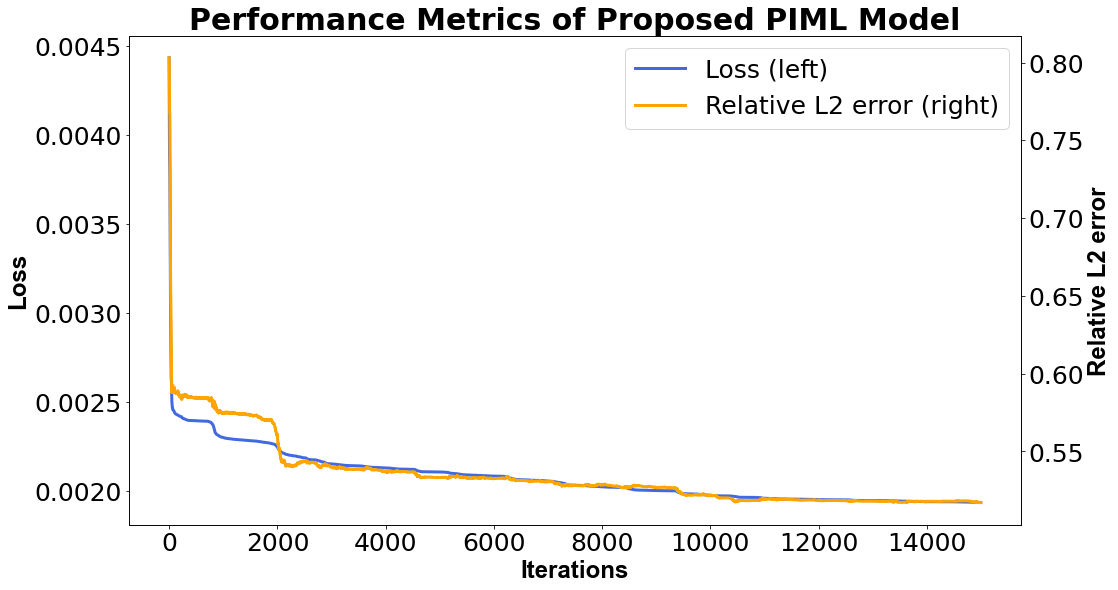

In [19]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [20]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.01971790133629231
MSE =  0.002513460828138944
RMSE =  0.05013442757366383
L2 relative error = 0.4762413388283305
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

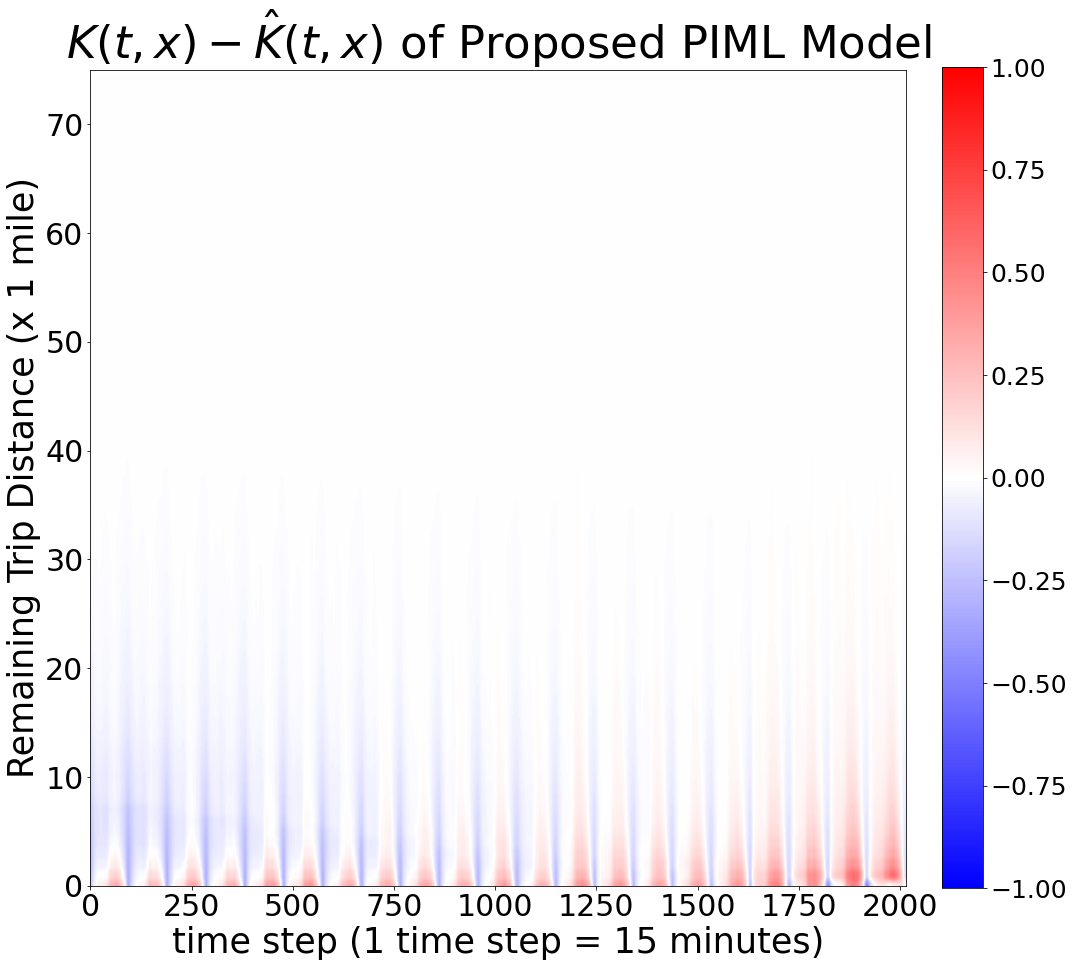

In [21]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

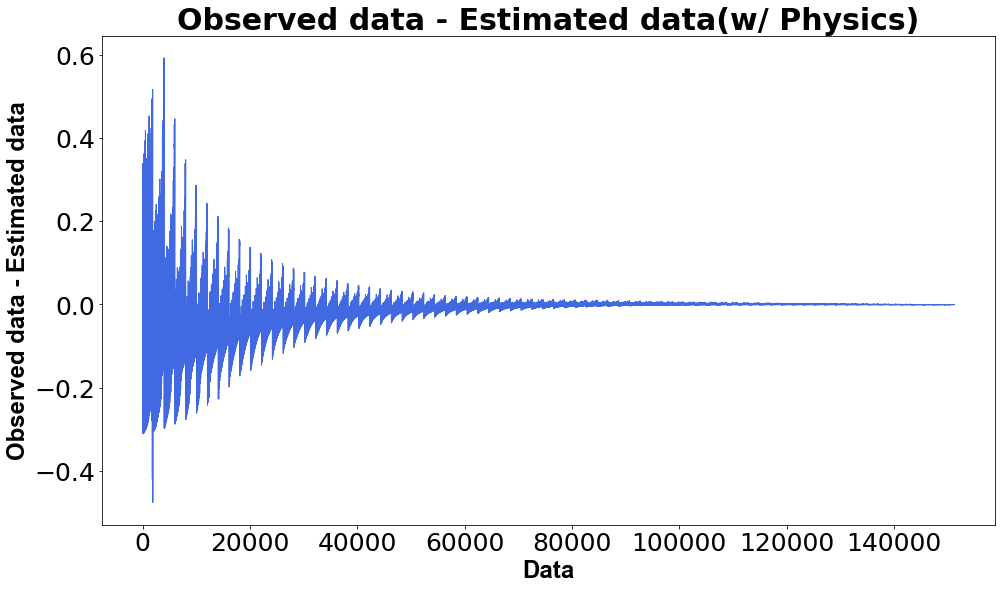

In [22]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

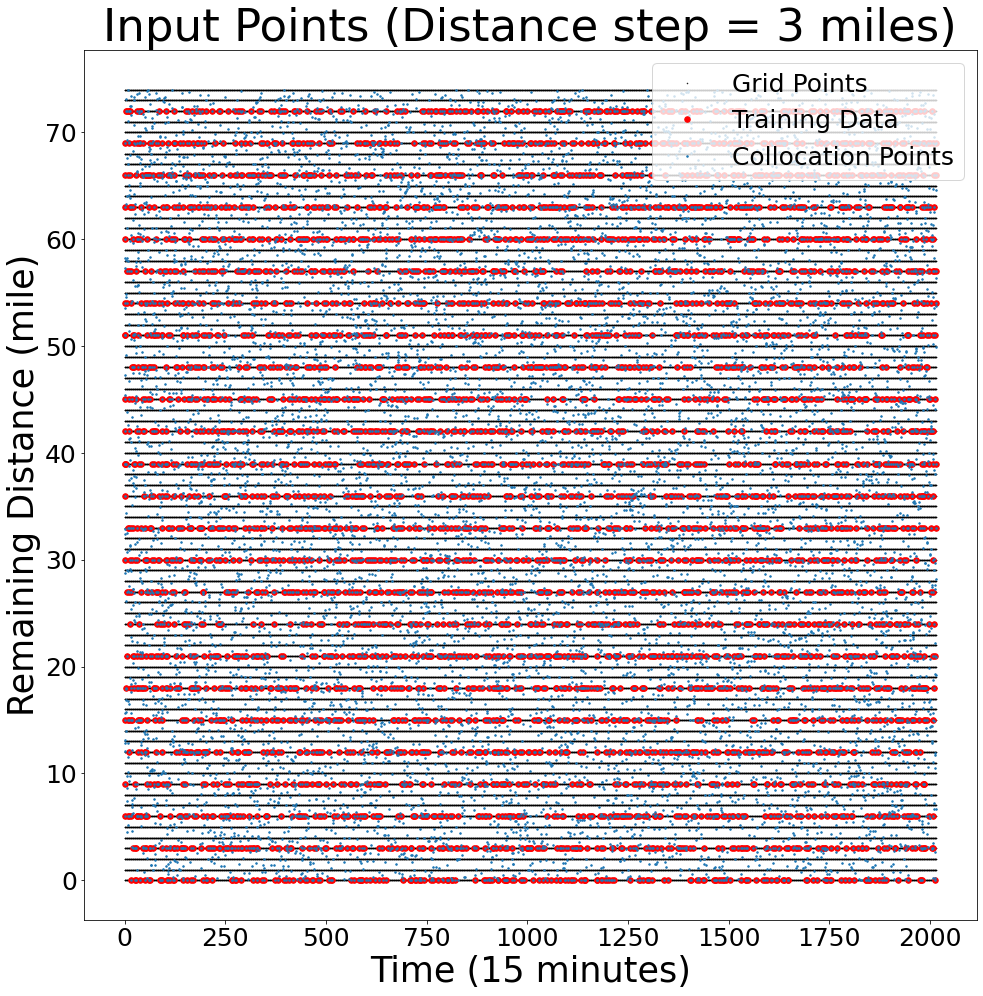

In [23]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 3 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

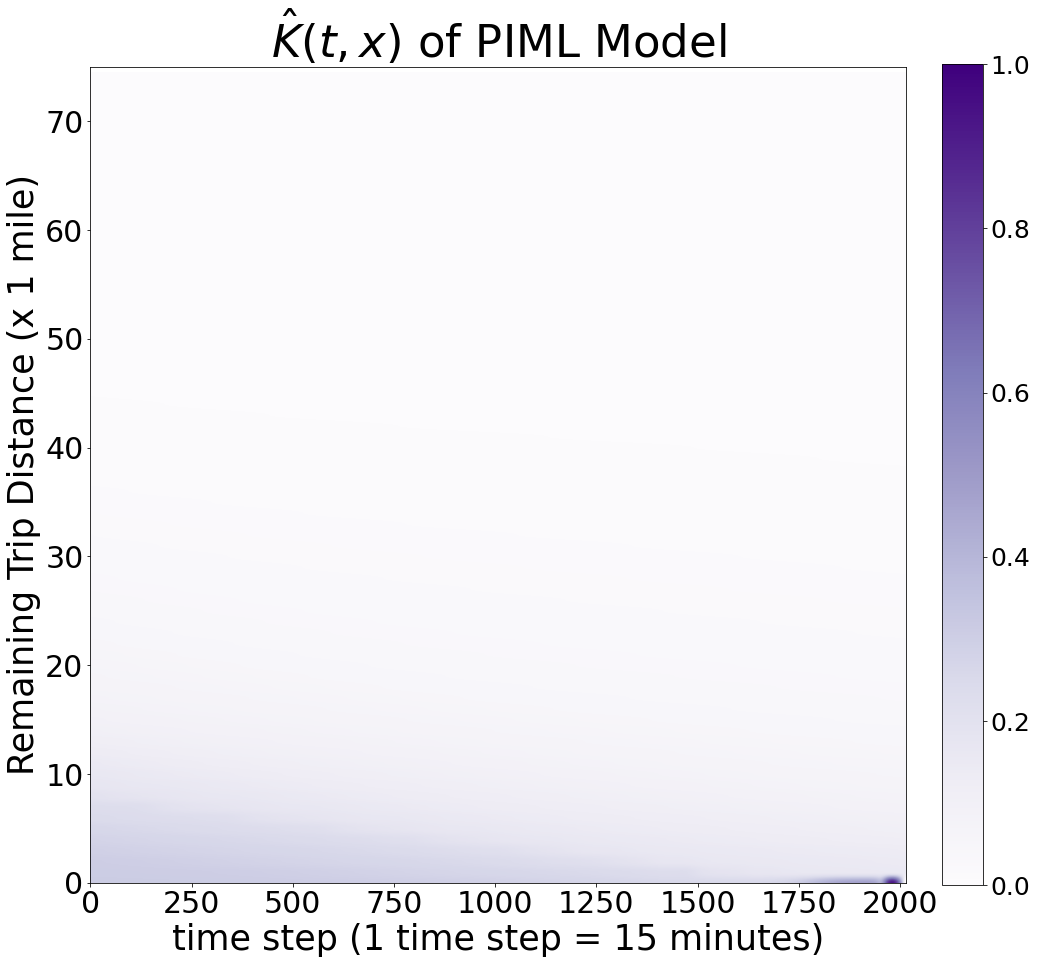

In [24]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

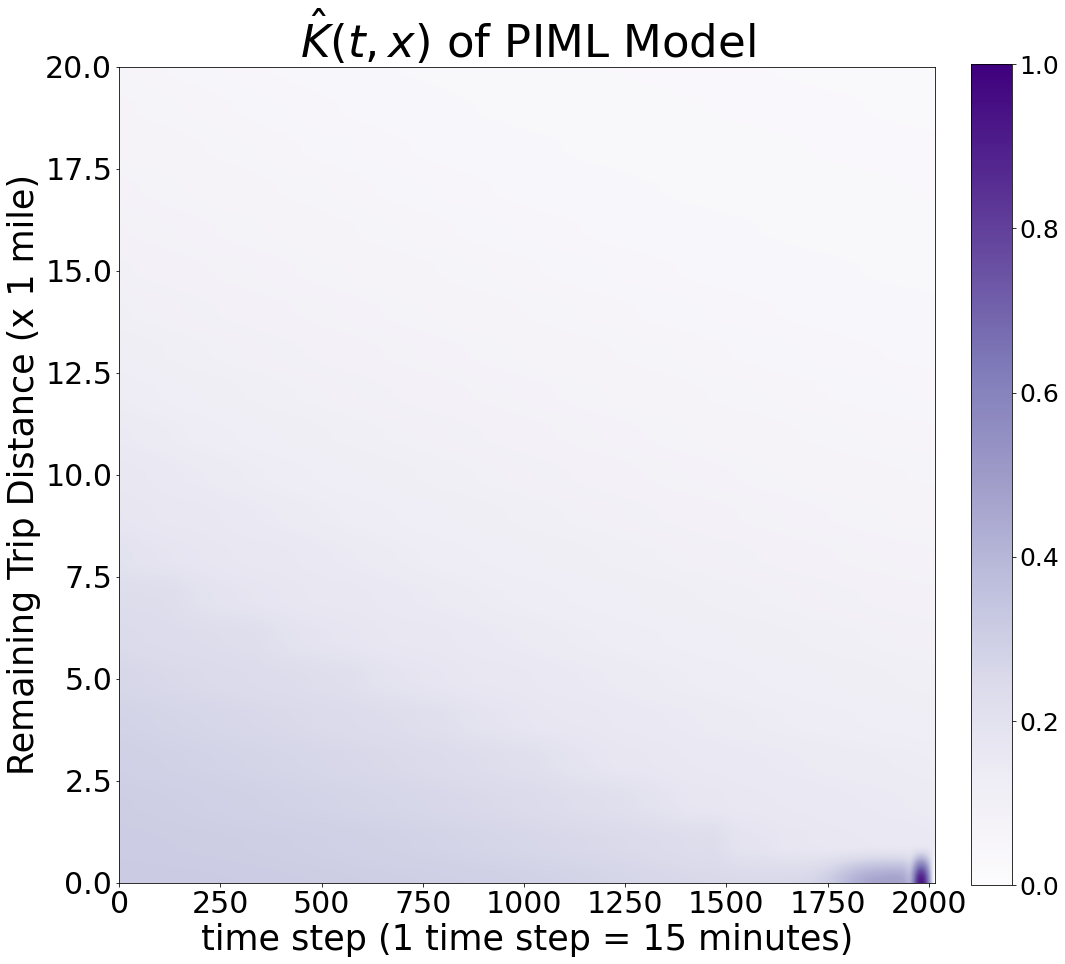

In [25]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

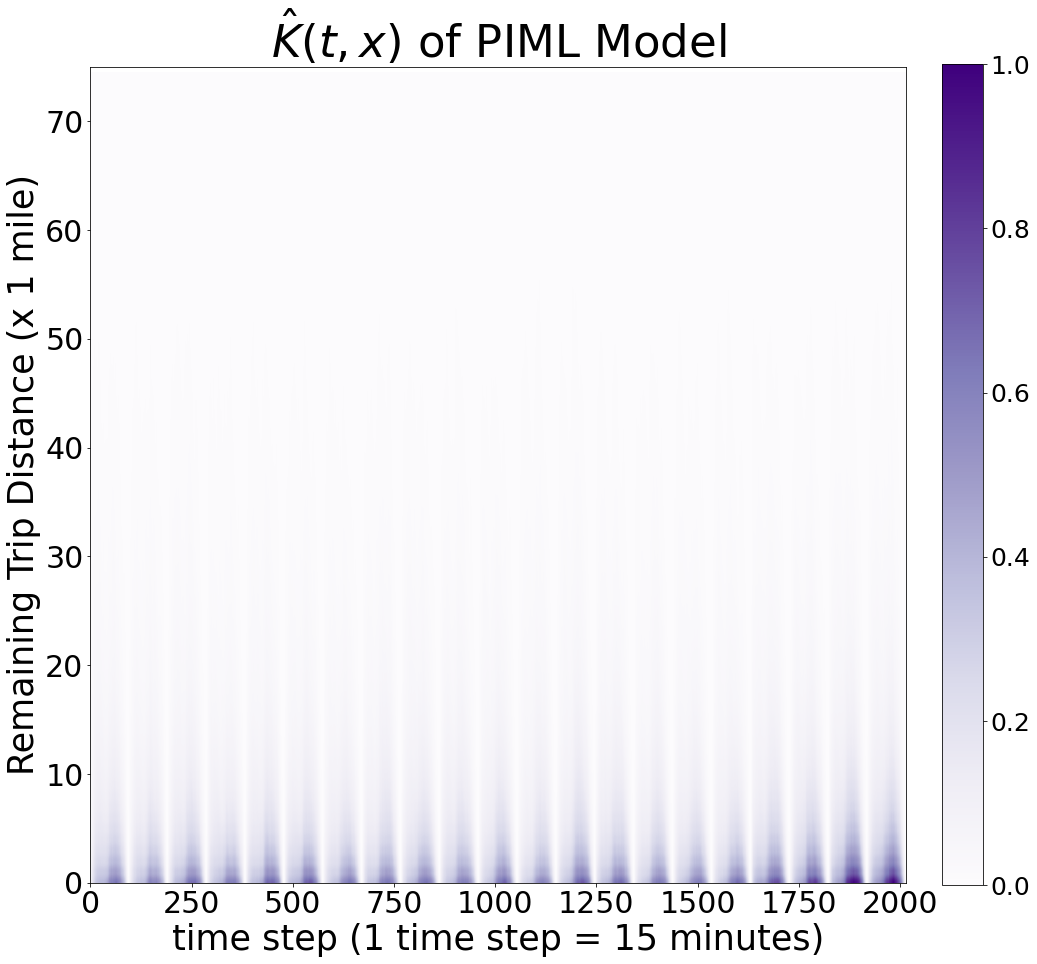

In [26]:
K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

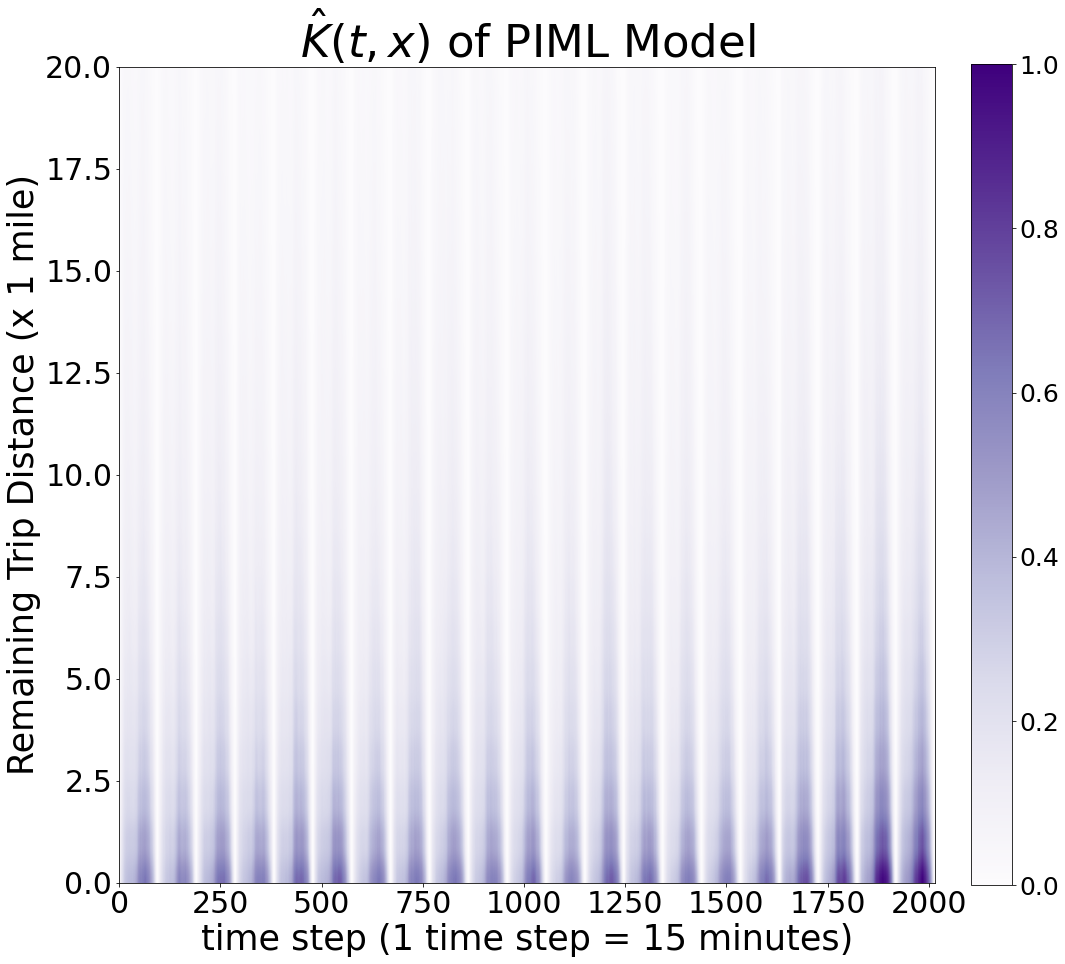

In [27]:
K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)